In [ ]:
# Connect to the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install segmentation_models
!pip install keras_applications==1.0.7
!pip install efficientnet==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: keras_applications
    Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8


In [ ]:
# change SM framework to tensorflow keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

# Set channels first, since the channels are the first dimension ( (2, 416, 704) for input, and (3, 416, 704) for output)
keras.backend.set_image_data_format('channels_first')

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Import libraries
from segmentation_models import Linknet, Unet, FPN
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import keras
import os
import pandas as pd
import numpy as np

In [ ]:
img_dir = '' # select the location of the input data
files = os.listdir(img_dir)

data = pd.read_csv(img_dir + "/" + files[0])
input_data = data.Y

mean_y = np.mean(input_data)
std_y  = np.std(input_data)

In [ ]:
# define custom dataset class
# For data loading during model train and testing
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
from torchvision.io import read_image

from sklearn.preprocessing import MinMaxScaler


class CustomImageDataset(Dataset):
    def __init__(self, label_dir, img_dir, annotation_dir, transform=None, target_transform=None):
        self.label_dir = label_dir
        self.annotations = pd.read_csv(annotation_dir, delimiter = ';') # to dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target_shape = (416, 704)
    def __len__(self):
        return len(os.listdir(self.label_dir))-2
        #return len(self.img_labels)

    def __getitem__(self, idx):
        # input data
        input_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        input = pd.read_csv(input_path)
        image = (input.Y-mean_y)/std_y
        image = pd.DataFrame(image.values.reshape(401, 701))
        image = np.pad(image, ((0, 15), (0, 3)), mode='constant')
        wind_inlet = input.inlet_wind_normal_surf_diff
        wind_inlet = pd.DataFrame(wind_inlet.values.reshape(401, 701))
        wind_inlet = np.pad(wind_inlet, ((0, 15), (0, 3)), mode='constant')
        input_data = np.stack((image, wind_inlet))

        # output data
        label_path = os.path.join(self.label_dir, self.annotations.iloc[idx, 1])
        label = pd.read_csv(label_path)

        U_0 = label.loc[:, "U_0"]
        U_0 = (U_0-np.mean(U_0))/np.std(U_0)

        U_1 = label.loc[:, "U_1"]
        U_1 = (U_1-np.mean(U_1))/np.std(U_1)

        U_2 = label.loc[:, "U_2"]
        U_2 = (U_2-np.mean(U_2))/np.std(U_2)

        U_0 = pd.DataFrame(U_0.values.reshape(401, 701))
        U_1 = pd.DataFrame(U_1.values.reshape(401, 701))
        U_2 = pd.DataFrame(U_2.values.reshape(401, 701))

        U_0 = np.pad(U_0, ((0, 15), (0, 3)), mode='constant')
        U_1 = np.pad(U_1, ((0, 15), (0, 3)), mode='constant')
        U_2 = np.pad(U_2, ((0, 15), (0, 3)), mode='constant')

        output_data = np.stack((U_0, U_1, U_2))

        return input_data, output_data

In [ ]:
# Define custom dataloader class
# for our specific data
from torch.utils.data import DataLoader
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# define cumtom dataset for the test set
class CustomImageDataset_test(Dataset):
    def __init__(self, label_dir, img_dir, transform=None, target_transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target_shape = (416, 704)
    def __len__(self):
        return 1
        #return len(self.img_labels)

    def __getitem__(self, idx):
        # input data
        input = pd.read_csv(self.img_dir)
        image = (input.Y-mean_y)/std_y
        image = pd.DataFrame(image.values.reshape(401, 701))
        image = np.pad(image, ((0, 15), (0, 3)), mode='constant')
        wind_inlet = input.inlet_wind_normal_surf_diff
        wind_inlet = pd.DataFrame(wind_inlet.values.reshape(401, 701))
        wind_inlet = np.pad(wind_inlet, ((0, 15), (0, 3)), mode='constant')
        input_data = np.stack((image, wind_inlet))

        label = pd.read_csv(self.label_dir)

        # output data
        U_0 = label.loc[:, "U_0"]
        U_0 = (U_0-np.mean(U_0))/np.std(U_0)

        U_1 = label.loc[:, "U_1"]
        U_1 = (U_1-np.mean(U_1))/np.std(U_1)

        U_2 = label.loc[:, "U_2"]
        U_2 = (U_2-np.mean(U_2))/np.std(U_2)

        U_0 = pd.DataFrame(U_0.values.reshape(401, 701))
        U_1 = pd.DataFrame(U_1.values.reshape(401, 701))
        U_2 = pd.DataFrame(U_2.values.reshape(401, 701))

        U_0 = np.pad(U_0, ((0, 15), (0, 3)), mode='constant')
        U_1 = np.pad(U_1, ((0, 15), (0, 3)), mode='constant')
        U_2 = np.pad(U_2, ((0, 15), (0, 3)), mode='constant')

        output_data = np.stack((U_0, U_1, U_2))

        return input_data, output_data

In [ ]:
# make the custom dataset
label_dir = '' # Give location of the output (target) data
img_dir = '' # Give location of the input data

annotation_dir = '' # Give the location of the annotation file

# define the dataset
dataset = CustomImageDataset(label_dir, img_dir, annotation_dir)

In [ ]:
annotations = pd.read_csv(annotation_dir, delimiter = ';')
annotations

,input_file,output_file
0,Copy of angle_-10_inlet_wind_normal_surf_diff.csv,Copy of angle_-10_export_postprocessing_U_DEM_...
1,Copy of angle_-40_inlet_wind_normal_surf_diff.csv,Copy of angle_-40_export_postprocessing_U_DEM_...
2,Copy of angle_-60_inlet_wind_normal_surf_diff.csv,Copy of angle_-60_export_postprocessing_U_DEM_...
3,Copy of angle_-70_inlet_wind_normal_surf_diff.csv,Copy of angle_-70_export_postprocessing_U_DEM_...
4,Copy of angle_0_inlet_wind_normal_surf_diff.csv,Copy of angle_0_export_postprocessing_U_DEM_be...
5,Copy of angle_10_inlet_wind_normal_surf_diff.csv,Copy of angle_10_export_postprocessing_U_DEM_b...
6,Copy of angle_30_inlet_wind_normal_surf_diff.csv,Copy of angle_30_export_postprocessing_U_DEM_b...
7,Copy of angle_40_inlet_wind_normal_surf_diff.csv,Copy of angle_40_export_postprocessing_U_DEM_b...
8,Copy of angle_50_inlet_wind_normal_surf_diff.csv,Copy of angle_50_export_postprocessing_U_DEM_b...
9,Copy of angle_20_inlet_wind_normal_surf_diff.csv,Copy of angle_20_export_postprocessing_U_DEM_b...


In [ ]:
# Extract the angle of the test fold

import re
def extract_angle(s):
    # Define the regular expression pattern to match the angle degrees
    pattern = r'angle_(-?\d+)_'

    # Search for the pattern in the string
    match = re.search(pattern, s)

    if match:
        # Extract the angle value and convert it to an integer
        angle = int(match.group(1))
        return angle
    else:
        raise ValueError("No valid angle found in the string")

## Plot the RMSE per inlet angle surface normal difference bin
- for every fold
- save the data to do a plot of the average RMSE per surface diff

In [ ]:
directory = '' # give the directory with all the trained model data

angle_dirs = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

/usr/local/lib/python3.10/dist-packages/keras_applications/imagenet_utils.py:269: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


1/1 [==============================] - 5s 5s/step


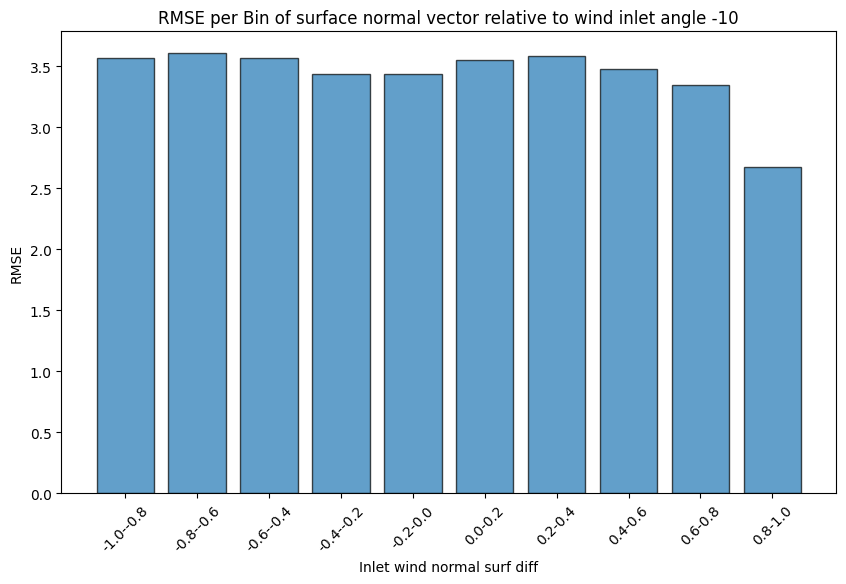

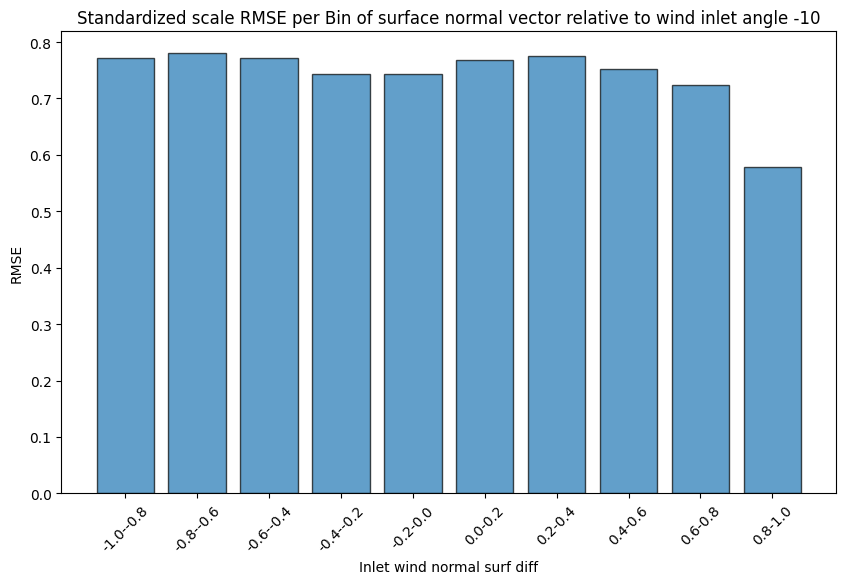

1/1 [==============================] - 0s 31ms/step


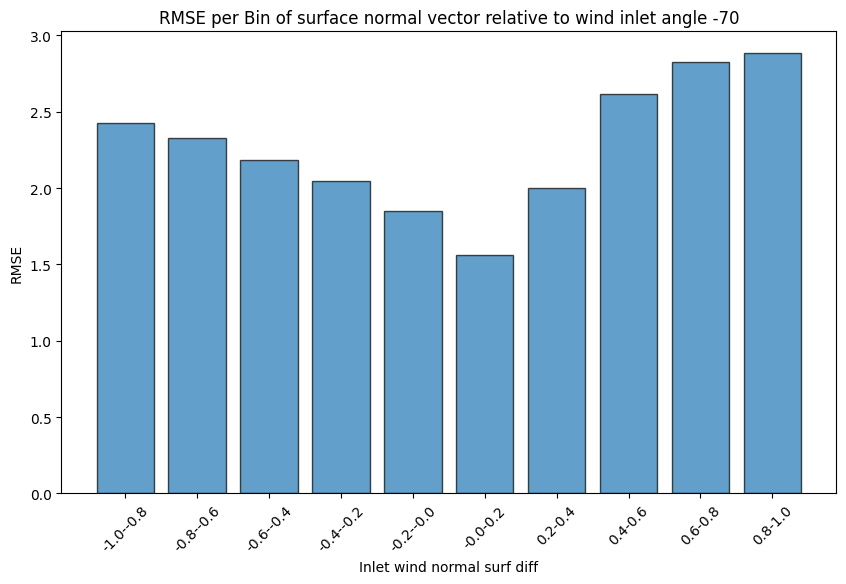

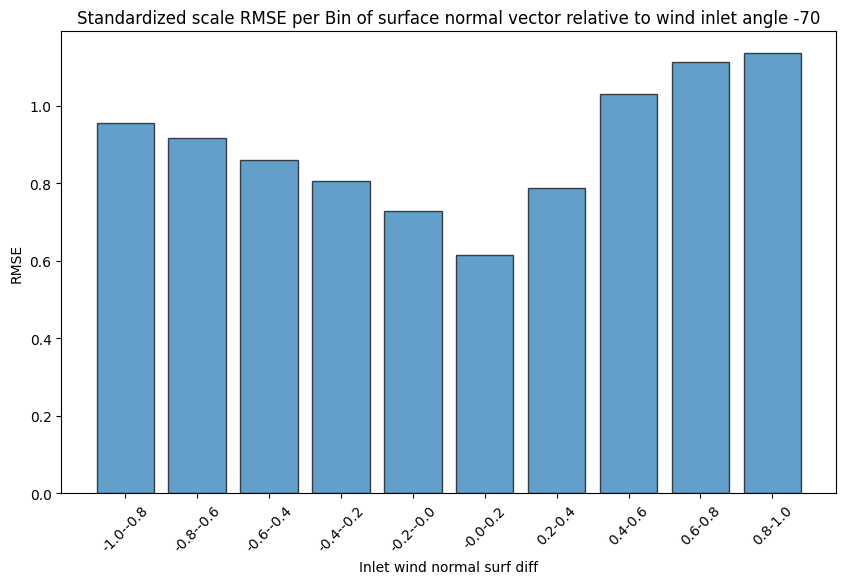

/usr/local/lib/python3.10/dist-packages/keras_applications/imagenet_utils.py:269: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


1/1 [==============================] - 3s 3s/step


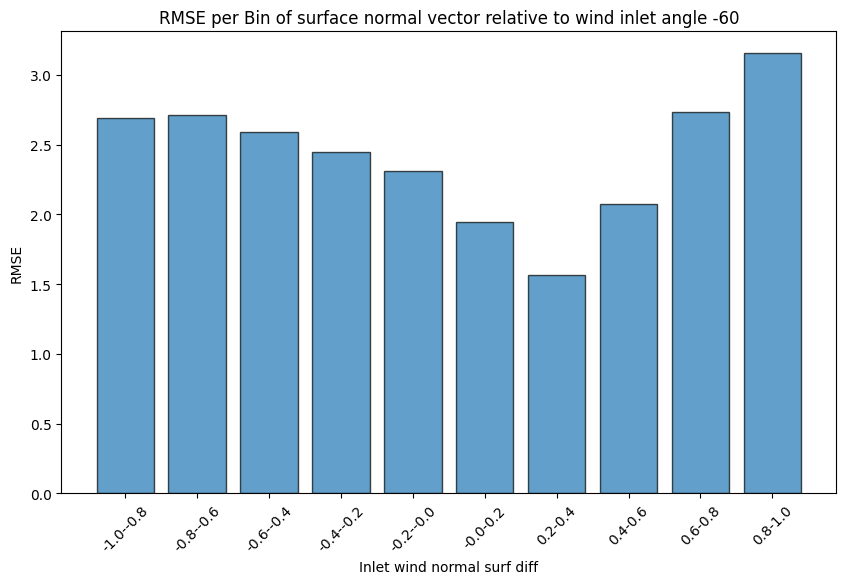

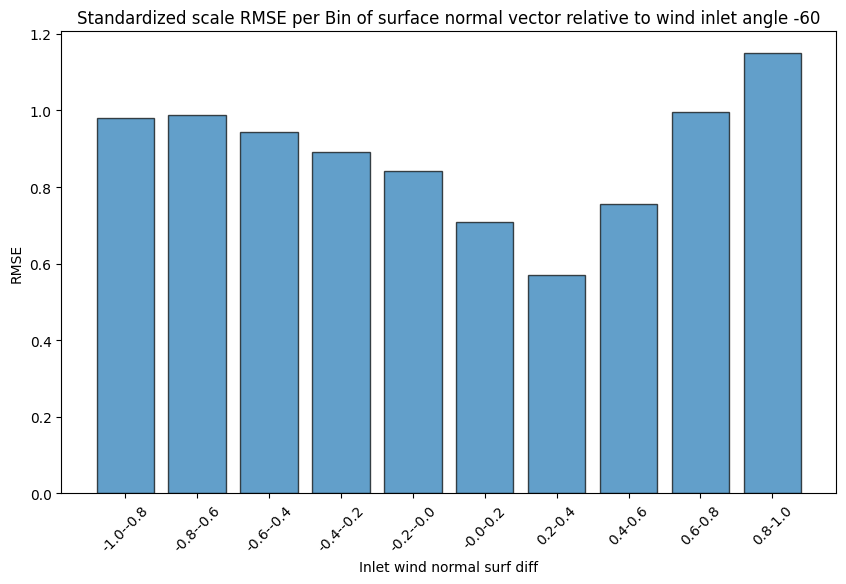

1/1 [==============================] - 0s 33ms/step


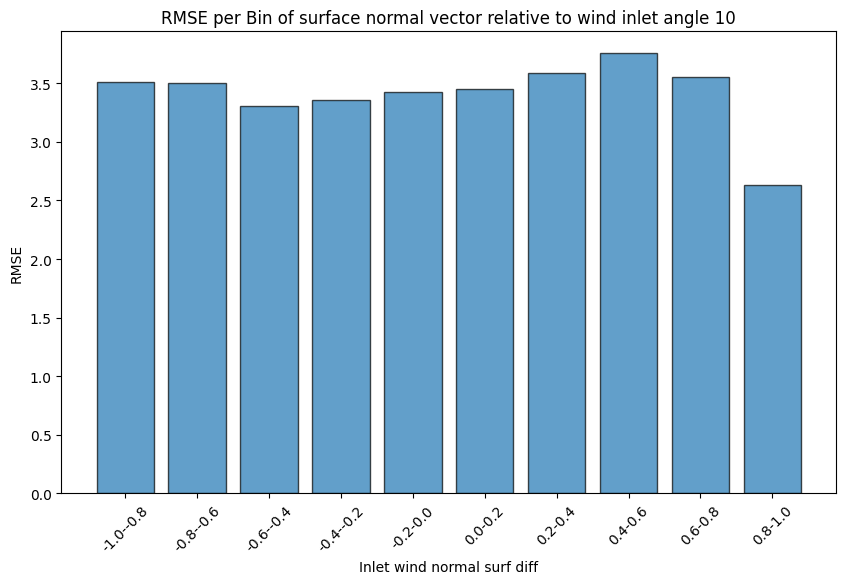

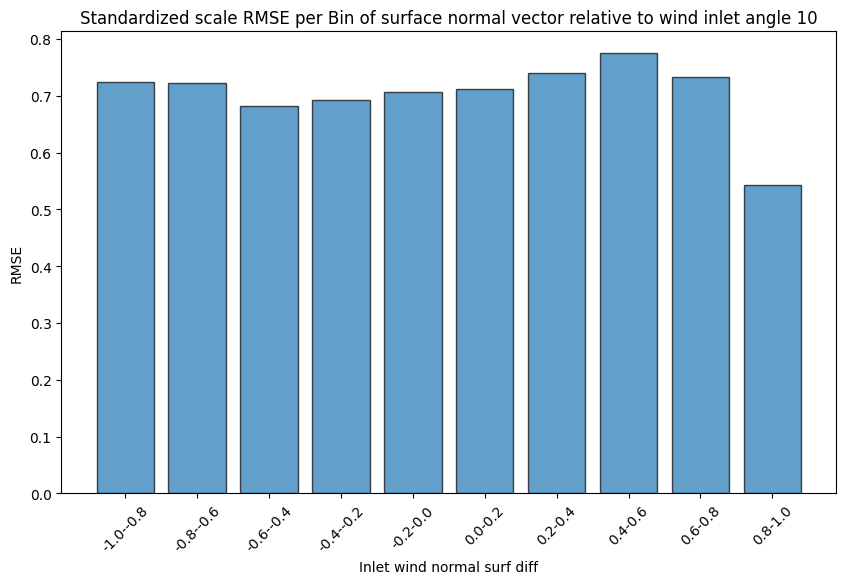

/usr/local/lib/python3.10/dist-packages/keras_applications/imagenet_utils.py:269: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


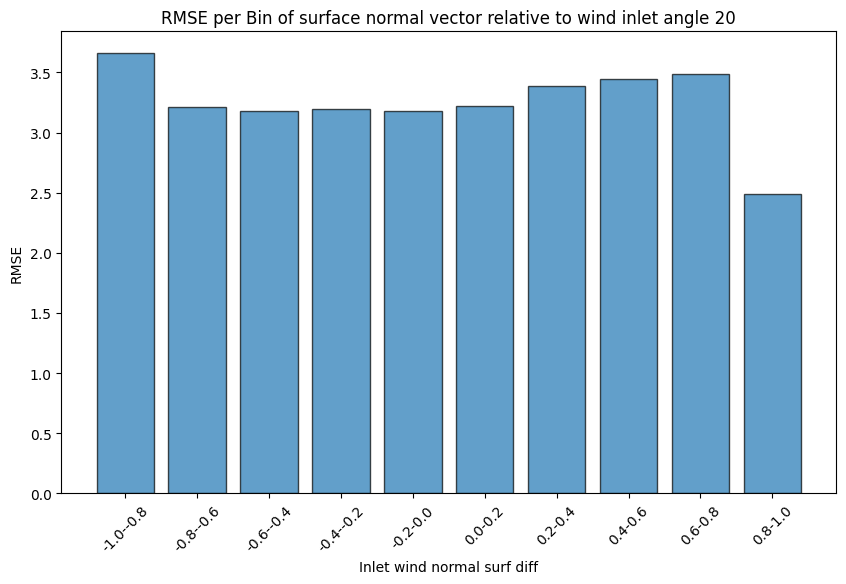

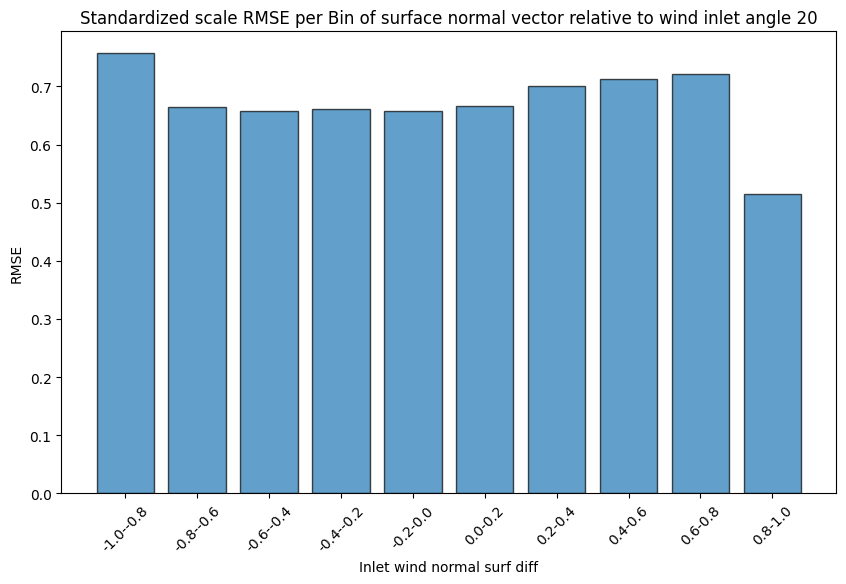

1/1 [==============================] - 0s 34ms/step


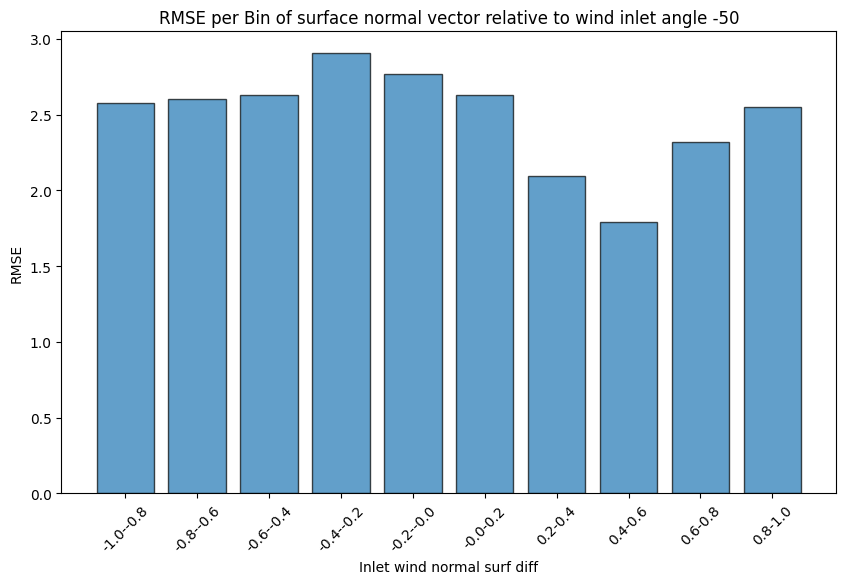

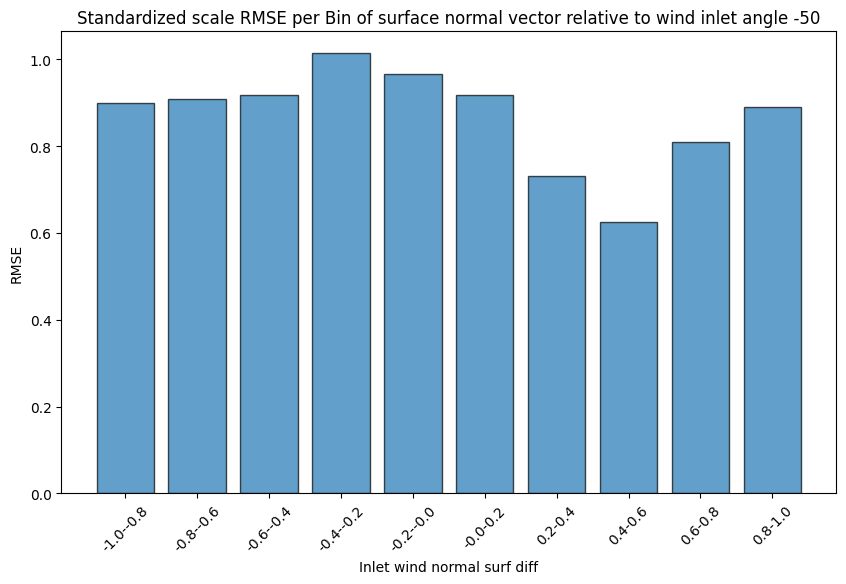

/usr/local/lib/python3.10/dist-packages/keras_applications/imagenet_utils.py:269: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


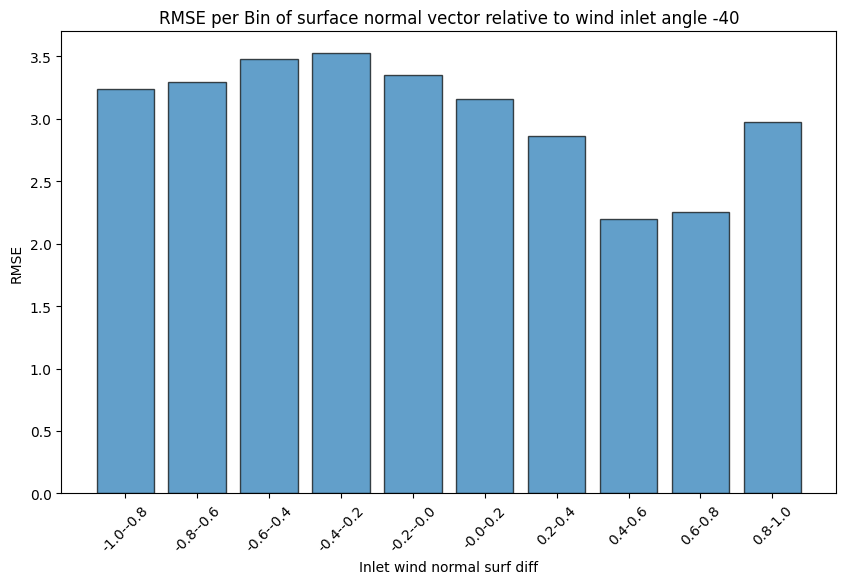

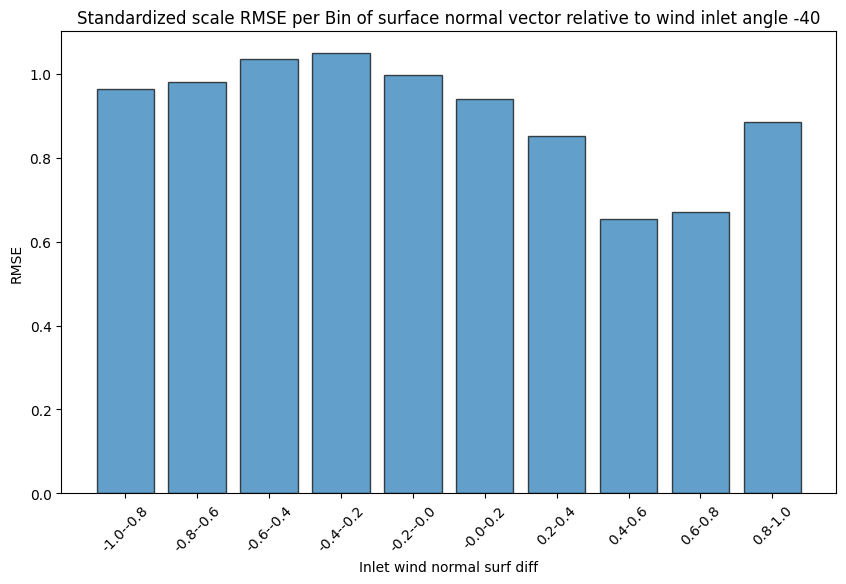

1/1 [==============================] - 0s 33ms/step


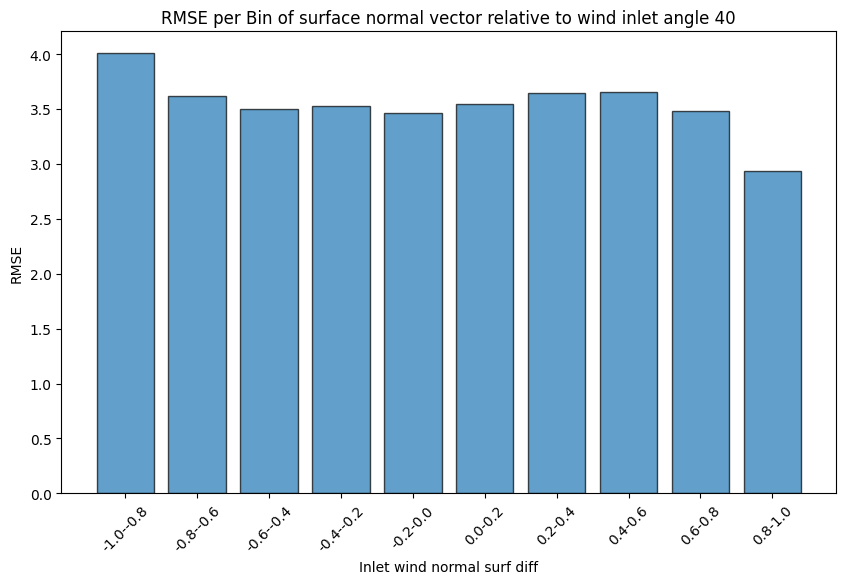

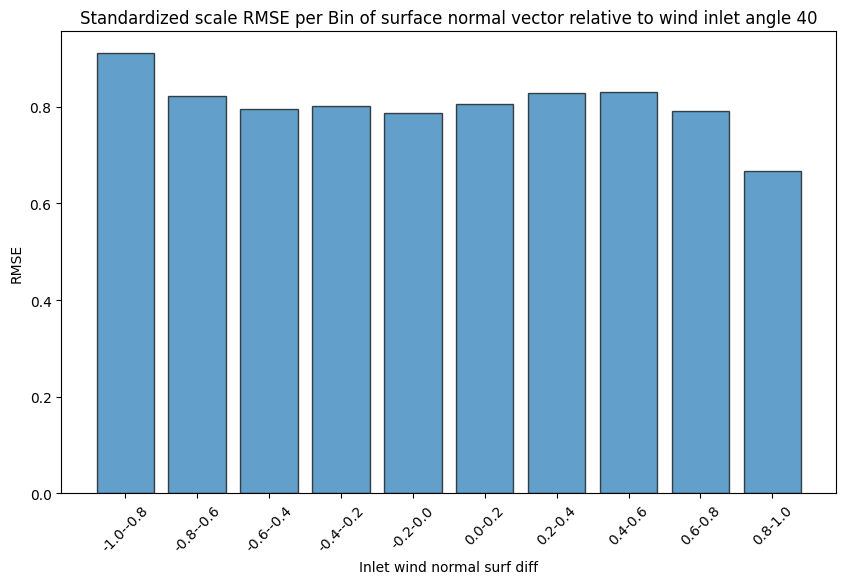

/usr/local/lib/python3.10/dist-packages/keras_applications/imagenet_utils.py:269: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


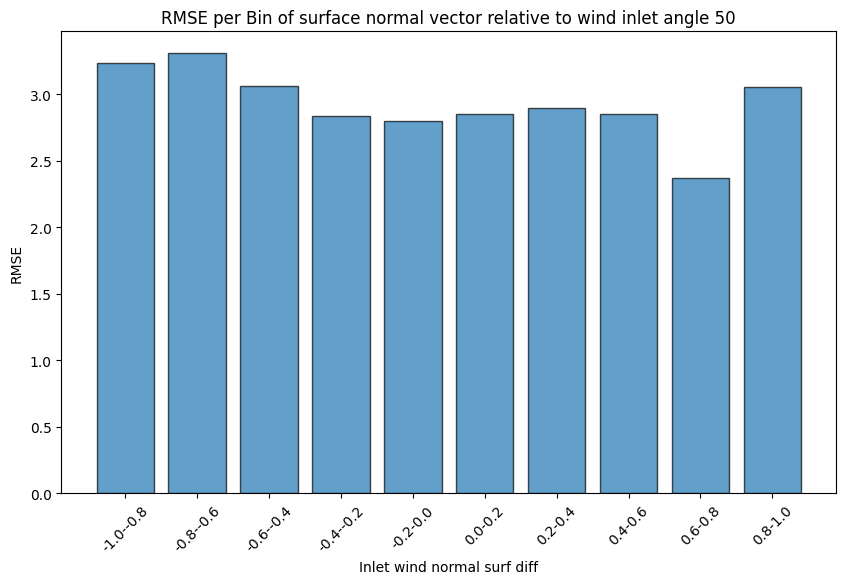

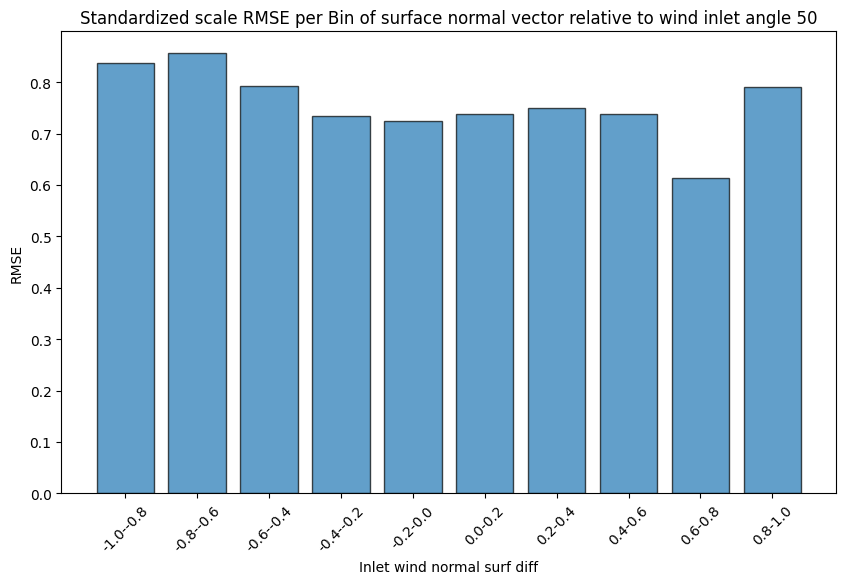

1/1 [==============================] - 0s 49ms/step


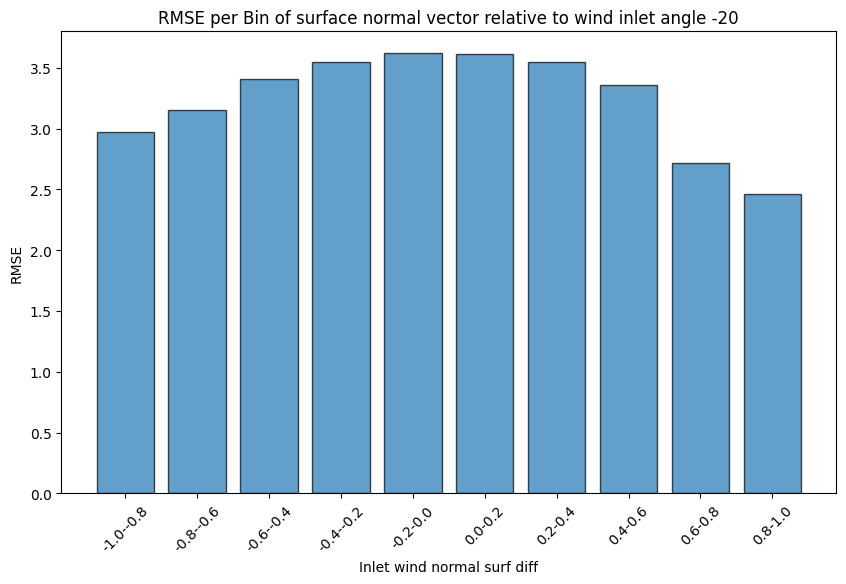

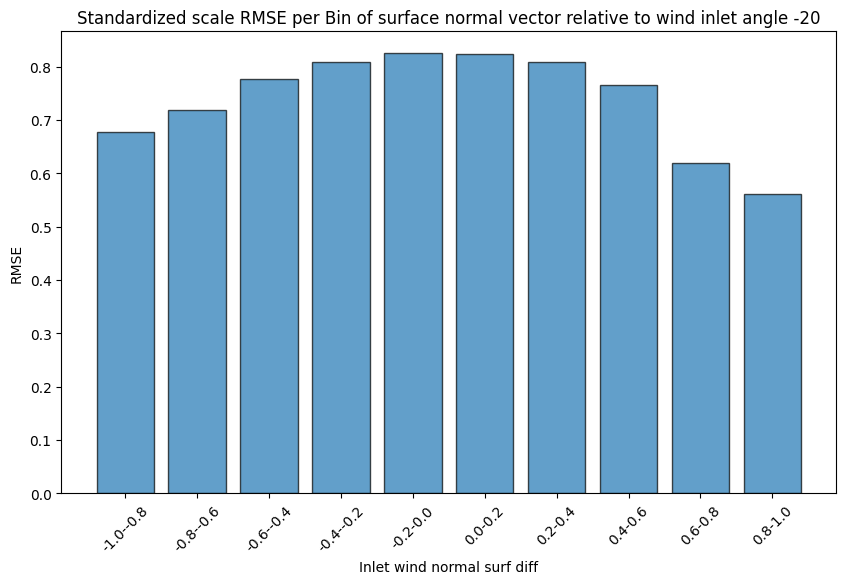

In [ ]:
# First load the dataloaders and model

from torch.utils.data import Subset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

# Define metric and loss function
metric = keras.metrics.RootMeanSquaredError()
loss = keras.losses.MeanSquaredError()

# Define backbone
backbone =  'densenet121' #'efficientnetb7'

for k in range(5):

  test_pair = test_indices[k]

  # Get the 2 test angles
  output_dir = annotations.output_file[test_indices[k][0]] #[test_pair[i]] # adjust to the correct LOOCV
  input_dir = annotations.input_file[test_indices[k][0]] #[test_pair[i]] # adjust to the correct LOOCV
  test_label = label_dir + "/" + output_dir
  angle1 = extract_angle(test_label)

  output_dir = annotations.output_file[test_indices[k][1]] #[test_pair[i]] # adjust to the correct LOOCV
  input_dir = annotations.input_file[test_indices[k][1]] #[test_pair[i]] # adjust to the correct LOOCV
  test_label = label_dir + "/" + output_dir
  angle2 = extract_angle(test_label)
  angles = [angle1, angle2]

  # Define test set
  test_set = Subset(dataset, test_indices[k])

  # Define loader
  test_loader = Dataloder(dataset = test_set)

  # Define & compile the model
  model = FPN(backbone_name=backbone, encoder_weights=None, input_shape=(2, None, None), classes = 3, activation = 'linear')
  model.compile('Adam', loss=loss, metrics=[metric])

  # Load the best model
  model.load_weights(directory + angle_dirs[k] + '/best_model.h5')


  # Now predict the data, save it to csv with the ground truth and angle diff data
  # And plot the RMSE per bin of the angle diff for each angle
  for i in range(len(test_loader)):
    # define empty df, to save the predictions in later on
    prediction_data = pd.DataFrame()

    angle = angles[i]

    # Predict on the correct testset
    prediction = model.predict(test_loader[i][0])


    # Compute the std and mean of the U_i to get the orgininal values
    label_path = os.path.join(label_dir, annotations.iloc[test_indices[k][i], 1])
    label = pd.read_csv(label_path)
    U_0 = label.loc[:, "U_0"]
    mean_0 = np.mean(U_0)
    std_0  = np.std(U_0)

    U_1 = label.loc[:, "U_1"]
    mean_1 = np.mean(U_1)
    std_1  = np.std(U_1)

    U_2 = label.loc[:, "U_2"]
    mean_2 = np.mean(U_2)
    std_2  = np.std(U_2)

    # define the ground_truths
    ground_truth_0 = U_0
    ground_truth_1 = U_1
    ground_truth_2 = U_2

    prediction_0 = prediction[0][0][:-15, :-3]*std_0 + mean_0
    prediction_1 = prediction[0][1][:-15, :-3]*std_1 + mean_1
    prediction_2 = prediction[0][2][:-15, :-3]*std_2 + mean_2
    predictions = [prediction_0, prediction_1, prediction_2]

    # reshape the values to an array
    prediction_0 = prediction_0.reshape(-1)
    prediction_1 = prediction_1.reshape(-1)
    prediction_2 = prediction_2.reshape(-1)


    image_path = os.path.join(img_dir, annotations.iloc[test_indices[k][i], 0])
    image = pd.read_csv(image_path)
    inlet_diff = image.inlet_wind_normal_surf_diff


    # save the prediction data
    prediction_data = pd.concat([prediction_data, U_0, U_1, U_2, pd.DataFrame(prediction_0), pd.DataFrame(prediction_1), pd.DataFrame(prediction_2), inlet_diff], axis = 1)


    ## Plot the graph

    # Define number of bins
    num_bins = 10

    # Bin the data
    bins = np.linspace(inlet_diff.min(), inlet_diff.max(), num_bins + 1)
    bin_indices = np.digitize(inlet_diff, bins) - 1

    # Calculate average errors per bin
    #avg_errors_per_bin = [errors[bin_indices == i].mean() for i in range(num_bins)]
    rmse_per_bin_U_0 = [np.sqrt(mean_squared_error(ground_truth_0[bin_indices == i], prediction_0[bin_indices == i])) for i in range(num_bins)]

    # Create a histogram
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_bins), rmse_per_bin_U_0, width=0.8, edgecolor='k', alpha=0.7)

    # Add labels and title
    plt.xlabel('Inlet wind normal surf diff')
    plt.ylabel('RMSE')
    plt.title(f'RMSE per Bin of surface normal vector relative to wind inlet angle {angle}')

    # Set x-axis ticks to bin ranges
    bin_ranges = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(num_bins)]
    plt.xticks(range(num_bins), bin_ranges, rotation=45)


    # Save the graph
    plt.savefig(directory + f'/Hist_angle_diff_with_rmse_{angle}.png')
    plt.show()

    ## repeat, only without rescaling to original

    # Rescale the predictions and ground truth data, also delete the padding
    ground_truth_0 = test_loader[i][1][0][0][:-15, :-3]#*std_0 + mean_0
    ground_truth_1 = test_loader[i][1][0][1][:-15, :-3]#*std_1 + mean_1
    ground_truth_2 = test_loader[i][1][0][2][:-15, :-3]#*std_2 + mean_2
    ground_truths = [ground_truth_0, ground_truth_1, ground_truth_2]

    prediction_0 = prediction[0][0][:-15, :-3]#*std_0 + mean_0
    prediction_1 = prediction[0][1][:-15, :-3]#*std_1 + mean_1
    prediction_2 = prediction[0][2][:-15, :-3]#*std_2 + mean_2
    predictions = [prediction_0, prediction_1, prediction_2]

    # reshape the values to an array
    ground_truth_0 = ground_truth_0.reshape(-1)
    ground_truth_1 = ground_truth_1.reshape(-1)
    ground_truth_2 = ground_truth_2.reshape(-1)

    prediction_0 = prediction_0.reshape(-1)
    prediction_1 = prediction_1.reshape(-1)
    prediction_2 = prediction_2.reshape(-1)

    # save the prediction data
    prediction_data = pd.concat([prediction_data, pd.DataFrame(ground_truth_0), pd.DataFrame(ground_truth_1), pd.DataFrame(ground_truth_2),
                                 pd.DataFrame(prediction_0), pd.DataFrame(prediction_1), pd.DataFrame(prediction_2)], axis = 1)
    prediction_data.columns = ['U_0', 'U_1', 'U_2', 'pred_U_0', 'pred_U_1', 'pred_U_2', 'inlet_diff', 'std_U_0', 'std_U_1', 'std_U_2', 'std_pred_U_0', 'std_pred_U_1', 'std_pred_U_2']
    prediction_data.to_csv(directory + f'prediction_data_angle_{angle}.csv')

    # Calculate average errors per bin
    #avg_errors_per_bin = [errors[bin_indices == i].mean() for i in range(num_bins)]
    standardized_rmse_per_bin_U_0 = [np.sqrt(mean_squared_error(ground_truth_0[bin_indices == i], prediction_0[bin_indices == i])) for i in range(num_bins)]

    # Create a histogram
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_bins), standardized_rmse_per_bin_U_0, width=0.8, edgecolor='k', alpha=0.7)

    # Add labels and title
    plt.xlabel('Inlet wind normal surf diff')
    plt.ylabel('RMSE')
    plt.title(f'Standardized scale RMSE per Bin of surface normal vector relative to wind inlet angle {angle}')

    # Set x-axis ticks to bin ranges
    bin_ranges = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(num_bins)]
    plt.xticks(range(num_bins), bin_ranges, rotation=45)

    # Save the graph
    plt.savefig(directory + f'/Hist_angle_diff_with_standardized_rmse_{angle}.png')
    plt.show()


In [ ]:
prediction_data.tail()

,U_0,U_1,U_2,pred_U_0,pred_U_1,pred_U_2,inlet_diff,std_U_0,std_U_1,std_U_2,std_pred_U_0,std_pred_U_1,std_pred_U_2
281096,5.36522,-0.032616,-8.39313,7.283988,0.394848,-6.130965,0.985212,-0.353983,-0.037237,0.263920,0.401765,0.420230,0.708953
281097,5.44586,0.007712,-8.56509,7.369446,0.344088,-6.400309,0.972066,-0.322221,0.005922,0.230090,0.435425,0.365907,0.655965
281098,5.38938,0.045222,-8.52620,7.433791,0.287373,-6.521397,0.913952,-0.344467,0.046064,0.237741,0.460768,0.305212,0.632144
281099,5.12608,0.072288,-8.14964,7.442296,0.220080,-6.571493,0.890587,-0.448174,0.075030,0.311821,0.464118,0.233195,0.622288
281100,4.93235,0.091121,-7.84804,7.409895,0.148657,-6.876681,0.927277,-0.524478,0.095185,0.371155,0.451356,0.156759,0.562249


## Plot the average RMSE per inlet angle surface diff bin
- Average of all the folds


In [ ]:
directory = '' # give the directory with the trained model data

In [ ]:
import os
import numpy as np
import pandas as pd

csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

In [ ]:
# Get the data for all of the folds combined

all_U_0 = np.array([])
all_U_1 = np.array([])
all_U_2 = np.array([])

all_pred_0 = np.array([])
all_pred_1 = np.array([])
all_pred_2 = np.array([])

all_std_U_0 = np.array([])
all_std_U_1 = np.array([])
all_std_U_2 = np.array([])

all_std_pred_0 = np.array([])
all_std_pred_1 = np.array([])
all_std_pred_2 = np.array([])

all_inlet_diff = np.array([])

for file in csv_files:
  data = pd.read_csv(directory + file)

  all_U_0 = np.append(all_U_0, data.U_0.values)
  all_U_1 = np.append(all_U_1, data.U_1.values)
  all_U_2 = np.append(all_U_2, data.U_2.values)


  all_pred_0 = np.append(all_pred_0, data.pred_U_0.values)
  all_pred_1 = np.append(all_pred_1, data.pred_U_1.values)
  all_pred_2 = np.append(all_pred_2, data.pred_U_2.values)

  all_inlet_diff = np.append(all_inlet_diff, data.inlet_diff.values)

  all_std_U_0 = np.append(all_std_U_0, data.std_U_0.values)
  all_std_U_1 = np.append(all_std_U_1, data.std_U_1.values)
  all_std_U_2 = np.append(all_std_U_2, data.std_U_2.values)


  all_std_pred_0 = np.append(all_std_pred_0, data.std_pred_U_0.values)
  all_std_pred_1 = np.append(all_std_pred_1, data.std_pred_U_1.values)
  all_std_pred_2 = np.append(all_std_pred_2, data.std_pred_U_0.values)


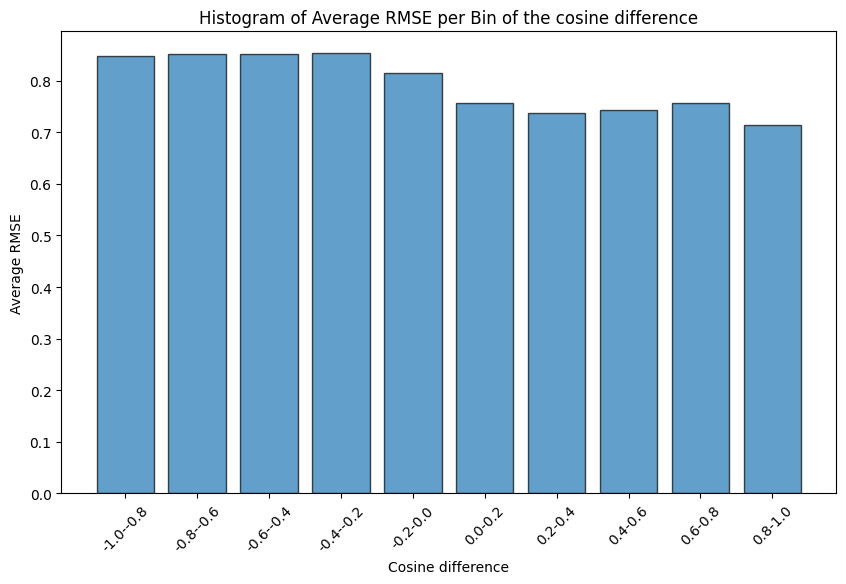

In [ ]:

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define number of bins
num_bins = 10

# Bin the data
bins = np.linspace(all_inlet_diff.min(), all_inlet_diff.max(), num_bins + 1)
bin_indices = np.digitize(all_inlet_diff, bins) - 1

# Calculate average errors per bin
avg_errors_per_bin = [np.sqrt(mean_squared_error(all_std_U_0[bin_indices == i], all_std_pred_0[bin_indices == i])) for i in range(num_bins)]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(range(num_bins), avg_errors_per_bin, width=0.8, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel('Cosine difference')
plt.ylabel('Average RMSE')
plt.title('Histogram of Average RMSE per Bin of the cosine difference')

# Set x-axis ticks to bin ranges
bin_ranges = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(num_bins)]
plt.xticks(range(num_bins), bin_ranges, rotation=45)

plt.show()

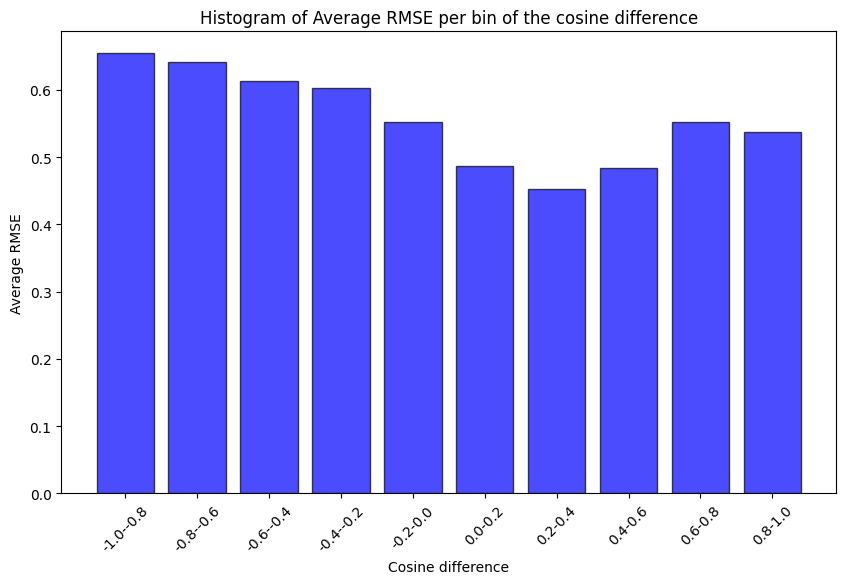

In [ ]:
# Calculate average errors per bin
#avg_errors_per_bin = [errors[bin_indices == i].mean() for i in range(num_bins)]
avg_errors_per_bin = [np.sqrt(mean_squared_error(all_std_U_1[bin_indices == i], all_std_pred_1[bin_indices == i])) for i in range(num_bins)]


# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(range(num_bins), avg_errors_per_bin, width=0.8, edgecolor='k', alpha=0.7, color = 'blue')

# Add labels and title
plt.xlabel('Cosine difference')
plt.ylabel('Average RMSE')
plt.title('Histogram of Average RMSE per bin of the cosine difference')

# Set x-axis ticks to bin ranges
bin_ranges = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(num_bins)]
plt.xticks(range(num_bins), bin_ranges, rotation=45)

plt.show()

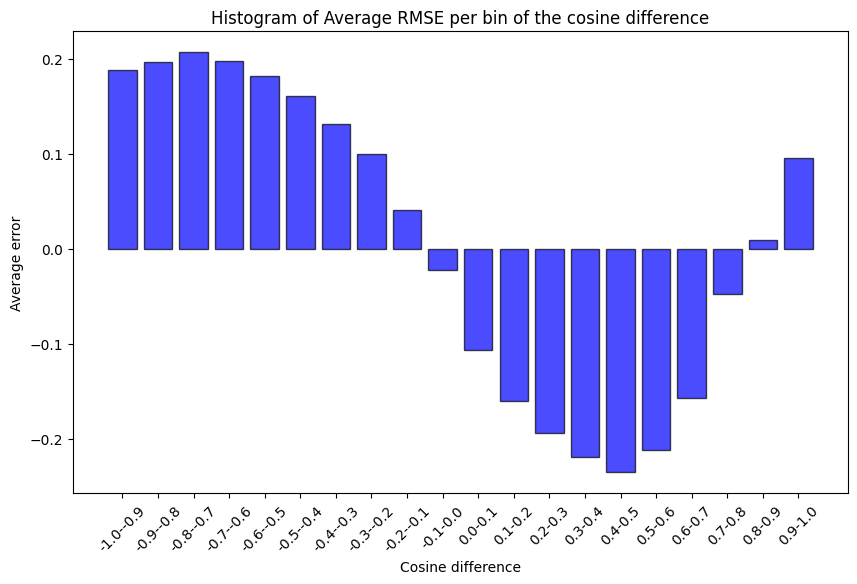

In [ ]:
## Now plot the mean error, not rmse or mse

# Define number of bins
num_bins = 20

# Bin the data
bins = np.linspace(all_inlet_diff.min(), all_inlet_diff.max(), num_bins + 1)
bin_indices = np.digitize(all_inlet_diff, bins) - 1

# Calculate average errors per bin
#avg_errors_per_bin = [errors[bin_indices == i].mean() for i in range(num_bins)]
avg_errors_per_bin = [np.mean(all_std_U_2[bin_indices == i] - all_std_pred_2[bin_indices == i]) for i in range(num_bins)]


# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(range(num_bins), avg_errors_per_bin, width=0.8, edgecolor='k', alpha=0.7, color = 'blue')

# Add labels and title
plt.xlabel('Cosine difference')
plt.ylabel('Average error')
plt.title('Histogram of Average RMSE per bin of the cosine difference')

# Set x-axis ticks to bin ranges
bin_ranges = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(num_bins)]
plt.xticks(range(num_bins), bin_ranges, rotation=45)

plt.show()

## Plot topo with error data

In [ ]:
directory = '' # give the directory with the trained model data

In [ ]:
import os
import numpy as np
import pandas as pd

csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

In [ ]:
feature_list = ['U_0', 'U_1', 'U_2', 'pred_U_0', 'pred_U_1', 'pred_U_2',
                'std_U_0', 'std_U_1', 'std_U_2', 'std_pred_U_0', 'std_pred_U_1', 'std_pred_U_2']
data = pd.DataFrame(0, index=np.arange(281101), columns=feature_list)

In [ ]:
# Get the data from all the folds

all_U_0 = np.array([])
all_U_1 = np.array([])
all_U_2 = np.array([])

all_pred_0 = np.array([])
all_pred_1 = np.array([])
all_pred_2 = np.array([])

all_std_U_0 = np.array([])
all_std_U_1 = np.array([])
all_std_U_2 = np.array([])

all_std_pred_0 = np.array([])
all_std_pred_1 = np.array([])
all_std_pred_2 = np.array([])

for file in csv_files:
  data = pd.read_csv(directory + file)

  all_U_0 = np.append(all_U_0, data.U_0.values)
  all_U_1 = np.append(all_U_1, data.U_1.values)
  all_U_2 = np.append(all_U_2, data.U_2.values)

  all_pred_0 = np.append(all_pred_0, data.pred_U_0.values)
  all_pred_1 = np.append(all_pred_1, data.pred_U_1.values)
  all_pred_2 = np.append(all_pred_2, data.pred_U_2.values)

  all_std_U_0 = np.append(all_std_U_0, data.std_U_0.values)
  all_std_U_1 = np.append(all_std_U_1, data.std_U_1.values)
  all_std_U_2 = np.append(all_std_U_2, data.std_U_2.values)

  all_std_pred_0 = np.append(all_std_pred_0, data.std_pred_U_0.values)
  all_std_pred_1 = np.append(all_std_pred_1, data.std_pred_U_1.values)
  all_std_pred_2 = np.append(all_std_pred_2, data.std_pred_U_0.values)


In [ ]:
feature_list = ['error_0' , 'error_1', 'error_2', 'magnitude_diff', 'angle_diff']
data = pd.DataFrame(0, index=np.arange(281101), columns=feature_list)

In [ ]:
for file in csv_files:
  new_data = pd.read_csv(directory + file)

  data.error_0 = data.error_0 + np.abs((new_data.U_0.values-new_data.pred_U_0.values)/len(csv_files))
  data.error_1 = data.error_1 + np.abs((new_data.U_1.values-new_data.pred_U_1.values)/len(csv_files))
  data.error_2 = data.error_2 + np.abs((new_data.U_2.values-new_data.pred_U_2.values)/len(csv_files))

  data.magnitude_diff = data.magnitude_diff + np.abs((compute_magnitude_difference(new_data.U_0, new_data.U_1, new_data.U_2, new_data.pred_U_0, new_data.pred_U_1, new_data.pred_U_2))/len(csv_files))

  data.angle_diff = data.angle_diff + np.abs((compute_angle_difference(new_data.U_0, new_data.U_1, new_data.U_2, new_data.pred_U_0, new_data.pred_U_1, new_data.pred_U_2))/len(csv_files))


In [ ]:
topo_dir = '' # Give directory of the topography data
topo = pd.read_csv(topo_dir)
topo = pd.DataFrame(topo.Y.values.reshape(401, 701))

In [ ]:
error_0 = pd.DataFrame(data.error_0.values.reshape(401, 701))
error_1 = pd.DataFrame(data.error_1.values.reshape(401, 701))
error_2 = pd.DataFrame(data.error_2.values.reshape(401, 701))

magnitude_diff_try = pd.DataFrame(data.magnitude_diff.values.reshape(401, 701))

angle_diff_try = pd.DataFrame(data.angle_diff.values.reshape(401, 701))

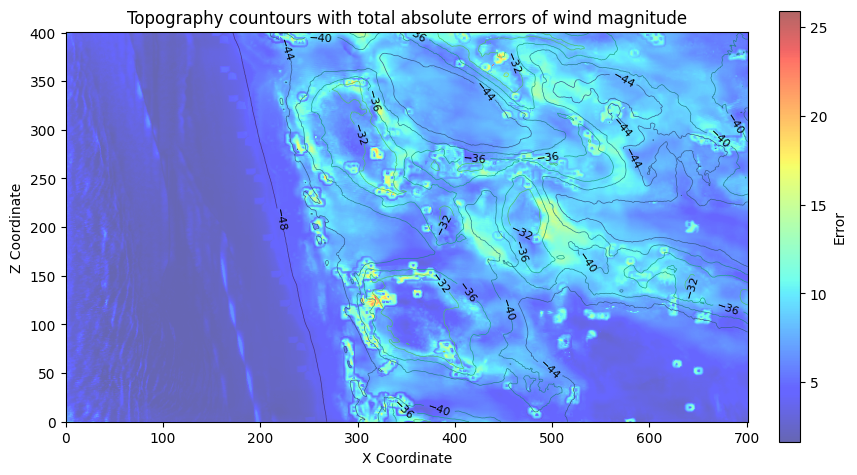

In [ ]:

# Create a new figure
plt.figure(figsize=(10, 8))

# Plot the error data with transparency
plt.imshow(error_0+error_1+error_2, cmap='jet', alpha=0.6, extent=[0, topo.shape[1], 0, topo.shape[0]], origin='lower')
plt.colorbar(label='Error', aspect=20, shrink=0.7, pad=0.04, fraction=0.08)

x = np.linspace(0, topo.shape[1], topo.shape[1])
y = np.linspace(0, topo.shape[0], topo.shape[0])
X, Y = np.meshgrid(x, y)
Z = topo  # Using topo as height data

# Overlay contour plot
contour = plt.contour(X, Y, Z, levels=5, cmap='viridis', linewidths=0.5)

# Add contour labels
plt.clabel(contour, inline=True, fontsize=8, colors='black')

# Add titles and labels
plt.title('Topography countours with total absolute errors of wind magnitude')
plt.xlabel('X Coordinate')
plt.ylabel('Z Coordinate')

# Show plot
plt.show()

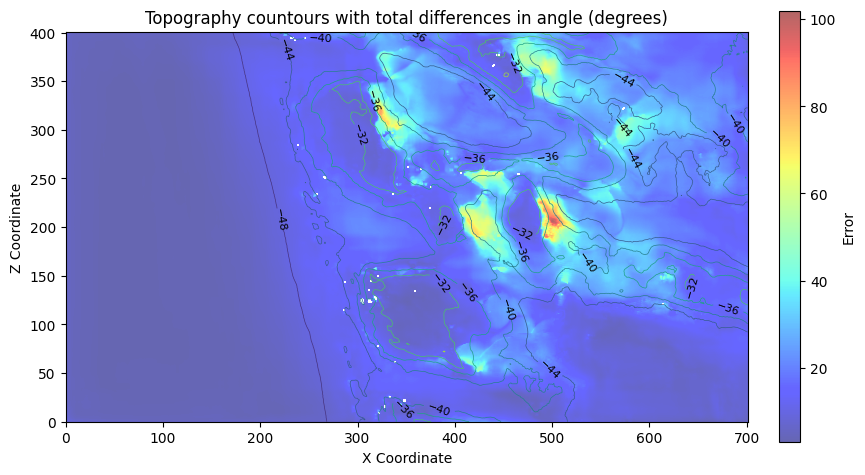

In [ ]:

# Create a new figure
plt.figure(figsize=(10, 8))

# Plot the error data with transparency
plt.imshow(angle_diff_try, cmap='jet', alpha=0.6, extent=[0, topo.shape[1], 0, topo.shape[0]], origin='lower')
plt.colorbar(label='Error', aspect=20, shrink=0.7, pad=0.04, fraction=0.08)

x = np.linspace(0, topo.shape[1], topo.shape[1])
y = np.linspace(0, topo.shape[0], topo.shape[0])
X, Y = np.meshgrid(x, y)
Z = topo  # Using topo as height data

# Overlay contour plot
contour = plt.contour(X, Y, Z, levels=5, cmap='viridis', linewidths=0.5)

# Add contour labels
plt.clabel(contour, inline=True, fontsize=8, colors='black')

# Add titles and labels
plt.title('Topography countours with total differences in angle (degrees)')
plt.xlabel('X Coordinate')
plt.ylabel('Z Coordinate')

# Show plot
plt.show()

## Plot the average wind inlet normal surface vector per inlet angle

In [ ]:
directory = '' # Give directory of the trained model data

In [ ]:
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

csv_files

['prediction_data_angle_-10.csv',
 'prediction_data_angle_-70.csv',
 'prediction_data_angle_-60.csv',
 'prediction_data_angle_10.csv',
 'prediction_data_angle_20.csv',
 'prediction_data_angle_-50.csv',
 'prediction_data_angle_-40.csv',
 'prediction_data_angle_40.csv',
 'prediction_data_angle_50.csv',
 'prediction_data_angle_-20.csv']

In [ ]:
# Extract the angle of the test fold
import re
def extract_angle(s):
    # Define the regular expression pattern to match the angle degrees
    pattern = r'_(-?\d+)\.csv$'

    # Search for the pattern in the string
    match = re.search(pattern, s)

    if match:
        # Extract the angle value and convert it to an integer
        angle = int(match.group(1))
        return angle
    else:
        raise ValueError("No valid angle found in the string")

In [ ]:
average_inlet_dict = {}

for file in csv_files:
  data = pd.read_csv(directory + file)
  angle = extract_angle(file)
  average_inlet_dict[f'{angle}'] = np.mean(data.inlet_diff)

In [ ]:
average_inlet_dict = dict(sorted(average_inlet_dict.items()))

In [ ]:
## Now create a dict with the pearsons correlation per angle on the inlet surface diff
dirX = '/content/drive/MyDrive/Thesis /data LOOCV/X data'
dirY = '/content/drive/MyDrive/Thesis /data LOOCV/Y data'

import os

x_data = os.listdir(dirX)
y_data = os.listdir(dirY)

from scipy.stats import pearsonr
import re

def extract_angle(filename):
    match = re.search(r'angle_(-?\d+)', filename)
    if match:
        return int(match.group(1))
    return None

inlet_wind_dict = {extract_angle(f): f for f in x_data}
export_dict = {extract_angle(f): f for f in y_data}

# Find common angles
all_angles = set(inlet_wind_dict.keys()).intersection(export_dict.keys())

In [ ]:
all_angles = sorted(all_angles)
all_angles

[-70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]

In [ ]:
import pandas as pd
# Dictionary to store correlations
correlations_dict = {}

from scipy.stats import pearsonr
for angle in all_angles:

  data = pd.read_csv(dirX+"/"+inlet_wind_dict[angle])
  angle_diff = data.inlet_wind_normal_surf_diff

  data_out = pd.read_csv(dirY+"/"+export_dict[angle])
  U_0 = data_out.U_0
  U_1 = data_out.U_1
  U_2 = data_out.U_2

  corr_0, _ = pearsonr(angle_diff, U_0)
  corr_1, _ = pearsonr(angle_diff, U_1)
  corr_2, _ = pearsonr(angle_diff, U_2)

  correlations_dict[angle] = {
        'corr_0': corr_0,
        'corr_1': corr_1,
        'corr_2': corr_2
    }
correlations_dict

{-70: {'corr_0': -0.18286653083699955,
  'corr_1': 0.4083394340011269,
  'corr_2': 0.10106757607021083},
 -60: {'corr_0': -0.03718829144261136,
  'corr_1': 0.475555739940447,
  'corr_2': 0.054580369404250206},
 -50: {'corr_0': 0.04513088267947883,
  'corr_1': 0.5055452386184733,
  'corr_2': -0.010847425016565375},
 -40: {'corr_0': 0.07180608909012522,
  'corr_1': 0.563351757745292,
  'corr_2': -0.049290292874117334},
 -30: {'corr_0': 0.09832832743537004,
  'corr_1': 0.5810863131859604,
  'corr_2': -0.05260622670936947},
 -20: {'corr_0': 0.11712638074192787,
  'corr_1': 0.6173772796132567,
  'corr_2': 0.006894344611033441},
 -10: {'corr_0': 0.16214504534420127,
  'corr_1': 0.6379211304494535,
  'corr_2': 0.09562885422511502},
 0: {'corr_0': 0.17778923036176986,
  'corr_1': 0.6455799817004999,
  'corr_2': 0.17049979923402786},
 10: {'corr_0': 0.20960948952732833,
  'corr_1': 0.6245838329797546,
  'corr_2': 0.19028339244318992},
 20: {'corr_0': 0.19744188522693046,
  'corr_1': 0.585827120

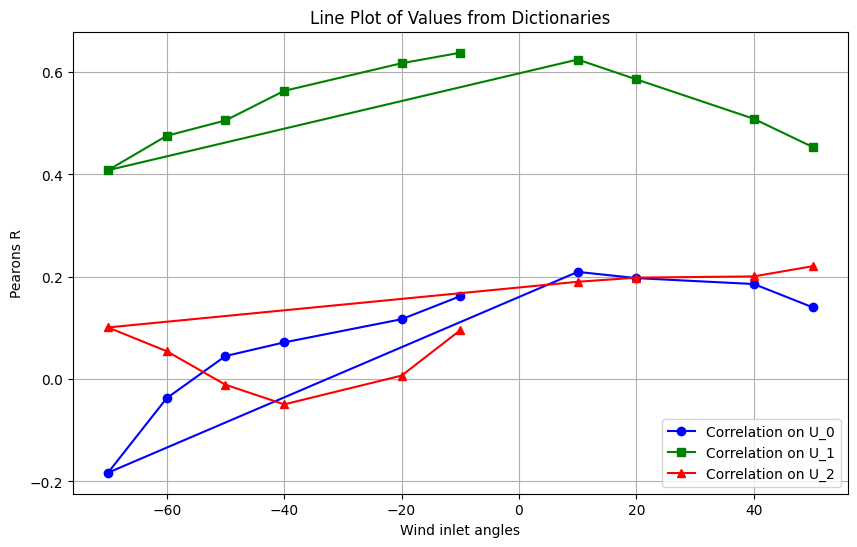

In [ ]:
# Extract keys and corresponding values from dict2
keys = list(map(int, average_inlet_dict.keys()))  # Convert keys to integers
values = list(average_inlet_dict.values())

# Initialize lists to store values for plotting
corr_0_values = []
corr_1_values = []
corr_2_values = []

# Extract values from dict1 and sort them based on the keys
for key in keys:
    corr_0_values.append(correlations_dict[key]['corr_0'])
    corr_1_values.append(correlations_dict[key]['corr_1'])
    corr_2_values.append(correlations_dict[key]['corr_2'])

# Plotting the lines
plt.figure(figsize=(10, 6))
plt.plot(keys, corr_0_values, marker='o', linestyle='-', color='b', label='corr_0')
plt.plot(keys, corr_1_values, marker='s', linestyle='-', color='g', label='corr_1')
plt.plot(keys, corr_2_values, marker='^', linestyle='-', color='r', label='corr_2')
#plt.plot(keys, values, marker='x', linestyle='-', color='k', label='dict2 values')

# Add labels, title, legend, and grid
plt.xlabel('Wind inlet angles')
plt.ylabel('Pearons R')
plt.title('Line Plot of Values from Dictionaries')
plt.legend(['Correlation on U_0', 'Correlation on U_1', 'Correlation on U_2'])
plt.grid(True)

# Show plot
plt.show()

In [ ]:
np.sort(keys)

array([-70, -60, -50, -40, -20, -10,  10,  20,  40,  50])

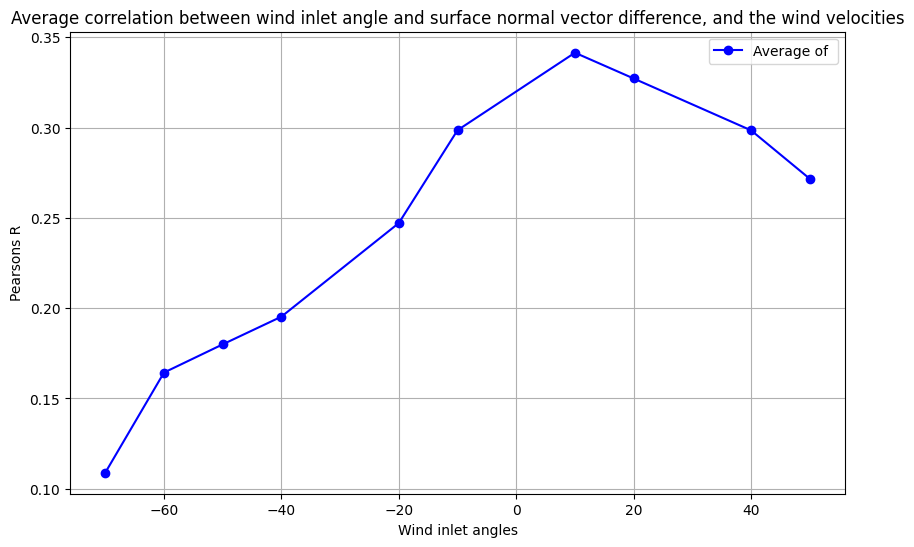

In [ ]:
# Extract keys and corresponding values from dict2
keys = list(map(int, average_inlet_dict.keys()))  # Convert keys to integers
keys = np.sort(keys)
values = list(average_inlet_dict.values())


# Initialize lists to store averages for plotting
averages = []

# Calculate averages from dict1 and sort them based on the keys
for key in keys:
    avg = np.mean([correlations_dict[key]['corr_0'], correlations_dict[key]['corr_1'], correlations_dict[key]['corr_2']])
    averages.append(avg)

# Plotting the average line
plt.figure(figsize=(10, 6))
plt.plot(keys, averages, marker='o', linestyle='-', color='b', label='Average of ')

# Add labels, title, legend, and grid
plt.xlabel('Wind inlet angles')
plt.ylabel('Pearsons R')
plt.title('Average correlation between wind inlet angle and surface normal vector difference, and the wind velocities')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Plot all the prediction of train and validation data with error
- for fold 1

In [ ]:
# select correct dir for the model
directory = '' # Get the directory with the trained model weights

angle_dirs = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

In [ ]:
# First load the dataloaders and model

from torch.utils.data import Subset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

# Define metric and loss function
metric = keras.metrics.RootMeanSquaredError()
loss = keras.losses.MeanSquaredError()

# Define backbone
backbone = 'densenet121'

k = 0 # fold number

test_pair = test_indices[k]

model_dir = directory + angle_dirs[k]

# Get the 2 test angles
output_dir = annotations.output_file[test_indices[k][0]] #[test_pair[i]] # adjust to the correct LOOCV
input_dir = annotations.input_file[test_indices[k][0]] #[test_pair[i]] # adjust to the correct LOOCV
test_label = label_dir + "/" + output_dir
angle1 = extract_angle(test_label)

output_dir = annotations.output_file[test_indices[k][1]] #[test_pair[i]] # adjust to the correct LOOCV
input_dir = annotations.input_file[test_indices[k][1]] #[test_pair[i]] # adjust to the correct LOOCV
test_label = label_dir + "/" + output_dir
angle2 = extract_angle(test_label)
angles = [angle1, angle2]

# Define test set
test_set = Subset(dataset, test_indices[k])

# Define validation set
validation_set = Subset(dataset, val_indices)

# Define train set
exclude = test_pair + val_indices
train_indices = np.arange(0, 13)            # Total of 13 datapoints
train_indices = np.delete(train_indices, exclude) # Exclude the test and validation datapoints from training
train_set = Subset(dataset, train_indices)

# Define loaders
train_loader = Dataloder(dataset = train_set)
validation_loader = Dataloder(dataset = validation_set)
test_loader = Dataloder(dataset = test_set)

# Define & compile the model
model = Unet(backbone_name=backbone, encoder_weights=None, input_shape=(2, None, None), classes = 3, activation = 'linear')
model.compile('Adam', loss=loss, metrics=[metric])

# Load the best model
model.load_weights(model_dir + '/best_model.h5')

In [ ]:
## plot all train angle predictions (fold k)
for i in range(len(train_loader)):
  output_dir = annotations.output_file[train_indices[i]]
  test_label = label_dir + "/" + output_dir
  angle = extract_angle(test_label)

  # Predict on the correct testset
  prediction = model.predict(train_loader[i][0])


  # Compute the std and mean of the U_i to get the orgininal values
  label_path = os.path.join(label_dir, annotations.iloc[train_indices[i], 1]) # Maak csv met alle namen van bestanden (X en Y)
  label = pd.read_csv(label_path) #self.img_labels.iloc[idx, 1] # to di
  U_0 = label.loc[:, "U_0"]
  mean_0 = np.mean(U_0)
  std_0  = np.std(U_0)

  U_1 = label.loc[:, "U_1"]
  mean_1 = np.mean(U_1)
  std_1  = np.std(U_1)

  U_2 = label.loc[:, "U_2"]
  mean_2 = np.mean(U_2)
  std_2  = np.std(U_2)


  # Rescale the predictions and ground truth data
  ground_truth_0 = train_loader[i][1][0][0][:-15, :-3]*std_0 + mean_0
  ground_truth_1 = train_loader[i][1][0][1][:-15, :-3]*std_1 + mean_1
  ground_truth_2 = train_loader[i][1][0][2][:-15, :-3]*std_2 + mean_2 # probably needs and extra [0] between [1] and [2]
  ground_truths = [ground_truth_0, ground_truth_1, ground_truth_2]

  prediction_0 = prediction[0][0][:-15, :-3]*std_0 + mean_0
  prediction_1 = prediction[0][1][:-15, :-3]*std_1 + mean_1
  prediction_2 = prediction[0][2][:-15, :-3]*std_2 + mean_2
  predictions = [prediction_0, prediction_1, prediction_2]

  # Compute model performance with fold i
  actual_rmse_value_0 = np.sqrt(mean_squared_error(ground_truth_0, prediction_0))
  actual_rmse_value_1 = np.sqrt(mean_squared_error(ground_truth_1, prediction_1))
  actual_rmse_value_2 = np.sqrt(mean_squared_error(ground_truth_2, prediction_2))
  actual_rmse = [actual_rmse_value_0, actual_rmse_value_1, actual_rmse_value_2]

  # Compute model performance with fold i
  standardized_rmse_value_0 = np.sqrt(mean_squared_error(train_loader[i][1][0][0][:-15, :-3], prediction[0][0][:-15, :-3]))
  standardized_rmse_value_1 = np.sqrt(mean_squared_error(train_loader[i][1][0][1][:-15, :-3], prediction[0][1][:-15, :-3]))
  standardized_rmse_value_2 = np.sqrt(mean_squared_error(train_loader[i][1][0][2][:-15, :-3], prediction[0][2][:-15, :-3]))
  standardized_rmse = [standardized_rmse_value_0, standardized_rmse_value_1, standardized_rmse_value_2]


  ## Save the different RMSE values in a txt file
  with open(model_dir + f'/actual_rmse_train_angle_{angle}.txt', 'w') as f:
      f.write(f"RMSE_0: {actual_rmse_value_0:.4f}\n")
      f.write(f"RMSE_1: {actual_rmse_value_1:.4f}\n")
      f.write(f"RMSE_2: {actual_rmse_value_2:.4f}\n")

  ## Save the different RMSE values in a txt file
  with open(model_dir + f'/standardized_rmse_train_angle_{angle}.txt', 'w') as f:
      f.write(f"RMSE_0: {standardized_rmse_value_0:.4f}\n")
      f.write(f"RMSE_1: {standardized_rmse_value_1:.4f}\n")
      f.write(f"RMSE_2: {standardized_rmse_value_2:.4f}\n")


  #Used to keep prediction and True velocity values on the same axis
  levels_U_0 = np.linspace(min(ground_truth_0.min(), prediction_0.min()), max(ground_truth_0.max(), prediction_0.max()), 100)
  levels_U_1 = np.linspace(min(ground_truth_1.min(), prediction_1.min()), max(ground_truth_1.max(), prediction_1.max()), 100)
  levels_U_2 = np.linspace(min(ground_truth_2.min(), prediction_2.min()), max(ground_truth_2.max(), prediction_2.max()), 100)
  levels = [levels_U_0, levels_U_1, levels_U_2]

  ## Plot and save the different graphs
  # Plot the different graphs
  fig, axes = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey=True)  # Create a figure with 3 subplots
  for j in range(3):
      # plot ground truths
      plot_values = ground_truths[j] # Adjust this according to your data structure
      ax = axes[0, j]
      p1 = ax.contourf(plot_values, levels=levels[j], cmap='jet')
      fig.colorbar(p1, ax=ax)
      ax.title.set_text(f'Ground truth U_{j} of angle {angle}')
      ax.set_xlabel('X-axis')
      ax.set_ylabel('Z-axis')

      # plot predictions
      plot_values = predictions[j] # Adjust this according to your data structure
      ax = axes[1, j]
      p2 = ax.contourf(plot_values, levels=levels[j], cmap='jet')
      fig.colorbar(p2, ax=ax)
      ax.set_title(f'Prediction U_{j-3} of angle {angle}')
      ax.set_xlabel('X-axis')
      ax.set_ylabel('Z-axis')

      # plot errors
      plot_values = predictions[j] - ground_truths[j] # Adjust this according to your data structure
      ax = axes[2, j]
      p3 = ax.contourf(plot_values, levels=100, cmap='jet')
      fig.colorbar(p3, ax=ax)
      ax.set_title(f'Error U_{j} of angle {angle}, RMSE: {actual_rmse[j]:.2f} m/s')
      ax.set_xlabel('X-axis')
      ax.set_ylabel('Z-axis')

  plt.tight_layout()  # Adjust layout to prevent overlap
  # Save the graph
  plt.savefig(model_dir + f'/Graph_train_angle_{angle}.png')



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## plot all validation angle predictions (fold k)
for i in range(len(validation_loader)):
  output_dir = annotations.output_file[val_indices[i]]
  test_label = label_dir + "/" + output_dir
  angle = extract_angle(test_label)

  # Predict on the correct testset
  prediction = model.predict(validation_loader[i][0])


  # Compute the std and mean of the U_i to get the orgininal values
  label_path = os.path.join(label_dir, annotations.iloc[val_indices[i], 1]) # Maak csv met alle namen van bestanden (X en Y)
  label = pd.read_csv(label_path) #self.img_labels.iloc[idx, 1] # to di
  U_0 = label.loc[:, "U_0"]
  mean_0 = np.mean(U_0)
  std_0  = np.std(U_0)

  U_1 = label.loc[:, "U_1"]
  mean_1 = np.mean(U_1)
  std_1  = np.std(U_1)

  U_2 = label.loc[:, "U_2"]
  mean_2 = np.mean(U_2)
  std_2  = np.std(U_2)


  # Rescale the predictions and ground truth data
  ground_truth_0 = validation_loader[i][1][0][0][:-15, :-3]*std_0 + mean_0
  ground_truth_1 = validation_loader[i][1][0][1][:-15, :-3]*std_1 + mean_1
  ground_truth_2 = validation_loader[i][1][0][2][:-15, :-3]*std_2 + mean_2 # probably needs and extra [0] between [1] and [2]
  ground_truths = [ground_truth_0, ground_truth_1, ground_truth_2]

  prediction_0 = prediction[0][0][:-15, :-3]*std_0 + mean_0
  prediction_1 = prediction[0][1][:-15, :-3]*std_1 + mean_1
  prediction_2 = prediction[0][2][:-15, :-3]*std_2 + mean_2
  predictions = [prediction_0, prediction_1, prediction_2]

  # Compute model performance with fold i
  actual_rmse_value_0 = np.sqrt(mean_squared_error(ground_truth_0, prediction_0))
  actual_rmse_value_1 = np.sqrt(mean_squared_error(ground_truth_1, prediction_1))
  actual_rmse_value_2 = np.sqrt(mean_squared_error(ground_truth_2, prediction_2))
  actual_rmse = [actual_rmse_value_0, actual_rmse_value_1, actual_rmse_value_2]

  # Compute model performance with fold i
  standardized_rmse_value_0 = np.sqrt(mean_squared_error(validation_loader[i][1][0][0][:-15, :-3], prediction[0][0][:-15, :-3]))
  standardized_rmse_value_1 = np.sqrt(mean_squared_error(validation_loader[i][1][0][1][:-15, :-3], prediction[0][1][:-15, :-3]))
  standardized_rmse_value_2 = np.sqrt(mean_squared_error(validation_loader[i][1][0][2][:-15, :-3], prediction[0][2][:-15, :-3]))
  standardized_rmse = [standardized_rmse_value_0, standardized_rmse_value_1, standardized_rmse_value_2]


  ## Save the different RMSE values in a txt file
  with open(model_dir + f'/actual_rmse_validation_angle_{angle}.txt', 'w') as f:
      f.write(f"RMSE_0: {actual_rmse_value_0:.4f}\n")
      f.write(f"RMSE_1: {actual_rmse_value_1:.4f}\n")
      f.write(f"RMSE_2: {actual_rmse_value_2:.4f}\n")

  ## Save the different RMSE values in a txt file
  with open(model_dir + f'/standardized_rmse_validation_angle_{angle}.txt', 'w') as f:
      f.write(f"RMSE_0: {standardized_rmse_value_0:.4f}\n")
      f.write(f"RMSE_1: {standardized_rmse_value_1:.4f}\n")
      f.write(f"RMSE_2: {standardized_rmse_value_2:.4f}\n")


  #Used to keep prediction and True velocity values on the same axis
  levels_U_0 = np.linspace(min(ground_truth_0.min(), prediction_0.min()), max(ground_truth_0.max(), prediction_0.max()), 100)
  levels_U_1 = np.linspace(min(ground_truth_1.min(), prediction_1.min()), max(ground_truth_1.max(), prediction_1.max()), 100)
  levels_U_2 = np.linspace(min(ground_truth_2.min(), prediction_2.min()), max(ground_truth_2.max(), prediction_2.max()), 100)
  levels = [levels_U_0, levels_U_1, levels_U_2]

  ## Plot and save the different graphs
  # Plot the different graphs
  fig, axes = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey=True)  # Create a figure with 3 subplots
  for j in range(3):
      # plot ground truths
      plot_values = ground_truths[j] # Adjust this according to your data structure
      ax = axes[0, j]
      p1 = ax.contourf(plot_values, levels=levels[j], cmap='jet')
      fig.colorbar(p1, ax=ax)
      ax.title.set_text(f'Ground truth U_{j} of angle {angle}')
      ax.set_xlabel('X-axis')
      ax.set_ylabel('Z-axis')

      # plot predictions
      plot_values = predictions[j] # Adjust this according to your data structure
      ax = axes[1, j]
      p2 = ax.contourf(plot_values, levels=levels[j], cmap='jet')
      fig.colorbar(p2, ax=ax)
      ax.set_title(f'Prediction U_{j-3} of angle {angle}')
      ax.set_xlabel('X-axis')
      ax.set_ylabel('Z-axis')

      # plot errors
      plot_values = predictions[j] - ground_truths[j] # Adjust this according to your data structure
      ax = axes[2, j]
      p3 = ax.contourf(plot_values, levels=100, cmap='jet')
      fig.colorbar(p3, ax=ax)
      ax.set_title(f'Error U_{j} of angle {angle}, RMSE: {actual_rmse[j]:.2f} m/s')
      ax.set_xlabel('X-axis')
      ax.set_ylabel('Z-axis')

  plt.tight_layout()  # Adjust layout to prevent overlap
  # Save the graph
  plt.savefig(model_dir + f'/Graph_validation_angle_{angle}.png')



1/1 [==============================] - 0s 29ms/step


## Plot the wind statistics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = '' # give the dir with the trained model data

In [ ]:
import os
import numpy as np
import pandas as pd


csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

In [ ]:
feature_list = ['U_0', 'U_1', 'U_2', 'pred_U_0', 'pred_U_1', 'pred_U_2',
                'std_U_0', 'std_U_1', 'std_U_2', 'std_pred_U_0', 'std_pred_U_1', 'std_pred_U_2']
data = pd.DataFrame(0, index=np.arange(281101), columns=feature_list)

In [ ]:
all_U_0 = np.array([])
all_U_1 = np.array([])
all_U_2 = np.array([])

all_pred_0 = np.array([])
all_pred_1 = np.array([])
all_pred_2 = np.array([])

all_std_U_0 = np.array([])
all_std_U_1 = np.array([])
all_std_U_2 = np.array([])

all_std_pred_0 = np.array([])
all_std_pred_1 = np.array([])
all_std_pred_2 = np.array([])


for file in csv_files:
  data = pd.read_csv(directory + file)

  all_U_0 = np.append(all_U_0, data.U_0.values)
  all_U_1 = np.append(all_U_1, data.U_1.values)
  all_U_2 = np.append(all_U_2, data.U_2.values)


  all_pred_0 = np.append(all_pred_0, data.pred_U_0.values)
  all_pred_1 = np.append(all_pred_1, data.pred_U_1.values)
  all_pred_2 = np.append(all_pred_2, data.pred_U_2.values)

  all_std_U_0 = np.append(all_std_U_0, data.std_U_0.values)
  all_std_U_1 = np.append(all_std_U_1, data.std_U_1.values)
  all_std_U_2 = np.append(all_std_U_2, data.std_U_2.values)


  all_std_pred_0 = np.append(all_std_pred_0, data.std_pred_U_0.values)
  all_std_pred_1 = np.append(all_std_pred_1, data.std_pred_U_1.values)
  all_std_pred_2 = np.append(all_std_pred_2, data.std_pred_U_0.values)


In [ ]:
feature_list = ['error_0' , 'error_1', 'error_2']
data = pd.DataFrame(0, index=np.arange(281101), columns=feature_list)

In [ ]:
def compute_vector_magnitudes(U, V, W):

    return np.sqrt(U**2 + V**2 + W**2)



def compute_magnitude_difference(U, V, W, U_prime, V_prime, W_prime):

    mag1 = compute_vector_magnitudes(U, V, W)

    mag2 = compute_vector_magnitudes(U_prime, V_prime, W_prime)

    return mag1 - mag2 #np.abs(mag1 - mag2)



def compute_angle_difference(U, V, W, U_prime, V_prime, W_prime):

    dot_product = U * U_prime + V * V_prime + W * W_prime

    mag1 = compute_vector_magnitudes(U, V, W)

    mag2 = compute_vector_magnitudes(U_prime, V_prime, W_prime)



    cos_theta = dot_product / (mag1 * mag2)

    # I'm not sure if the np.clip is necessary??

    # Ensure the values are within [-1, 1] to avoid NaN due to numerical errors

    #cos_theta = np.clip(cos_theta, -1, 1)



    angles = np.arccos(cos_theta)

    return np.degrees(angles)

In [ ]:
# Extract the angle of the test fold

import re
def extract_angle(s):
    # Define the regular expression pattern to match the angle degrees
    pattern = r'angle_(-?\d+).csv'

    # Search for the pattern in the string
    match = re.search(pattern, s)

    if match:
        # Extract the angle value and convert it to an integer
        angle = int(match.group(1))
        return angle
    else:
        raise ValueError("No valid angle found in the string")


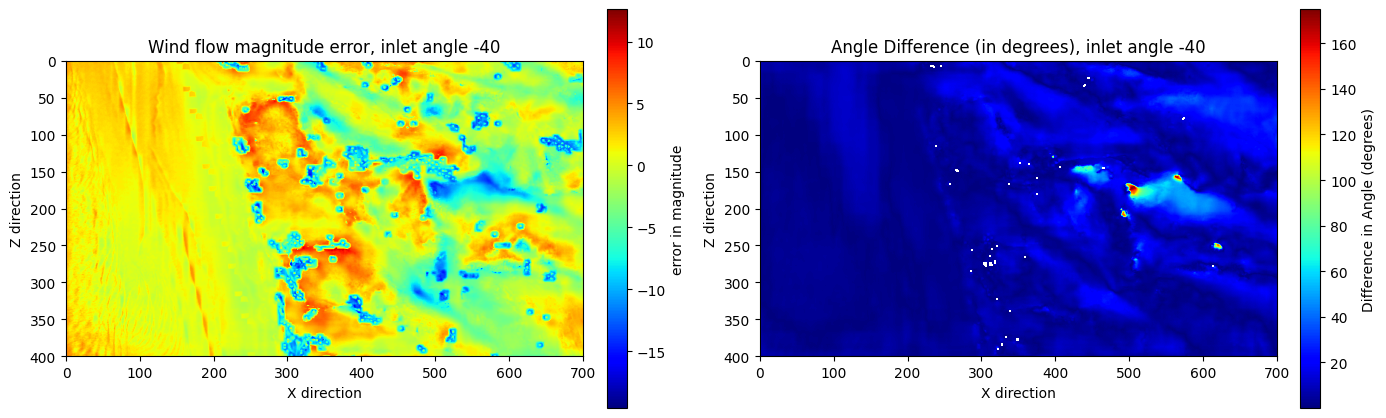

In [ ]:
file = csv_files[6]
angle = extract_angle(file)
new_data = pd.read_csv(directory + file)
magnitude_diff = compute_magnitude_difference(new_data.U_0, new_data.U_1, new_data.U_2, new_data.pred_U_0, new_data.pred_U_1, new_data.pred_U_2)
angle_diff = compute_angle_difference(new_data.U_0, new_data.U_1, new_data.U_2, new_data.pred_U_0, new_data.pred_U_1, new_data.pred_U_2)



magnitude_diff = pd.DataFrame(magnitude_diff.values.reshape(401, 701))
magnitude_diff = np.flipud(magnitude_diff)
angle_diff = pd.DataFrame(angle_diff.values.reshape(401, 701))
angle_diff = np.flipud(angle_diff)

import matplotlib.pyplot as plt
# Plotting the results

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title(f'Wind flow magnitude error, inlet angle {angle}')
plt.imshow(magnitude_diff, cmap='jet')#, origin='lower')
plt.colorbar(label='error in magnitude', aspect=20, shrink=0.7, pad=0.04, fraction=0.08)

plt.xlabel('X direction')
plt.ylabel('Z direction')

plt.subplot(1, 2, 2)
plt.title(f'Angle Difference (in degrees), inlet angle {angle}')
plt.imshow(angle_diff, cmap='jet')#, origin='lower')
plt.colorbar(label='Difference in Angle (degrees)', aspect=20, shrink=0.7, pad=0.04, fraction=0.08)

plt.xlabel('X direction')
plt.ylabel('Z direction')

plt.tight_layout()

plt.show()

## Plot the U_0, U_1 or U_2 of an arbitrary angle to show the vortices

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = '' # Give dir with the trained model data

In [ ]:
import os
import numpy as np
import pandas as pd


csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

In [ ]:
data = pd.read_csv(directory + csv_files[3])

In [ ]:
U_0 = pd.DataFrame(data.U_0.values.reshape(401, 701))
U_0_flipped = np.flipud(U_0)

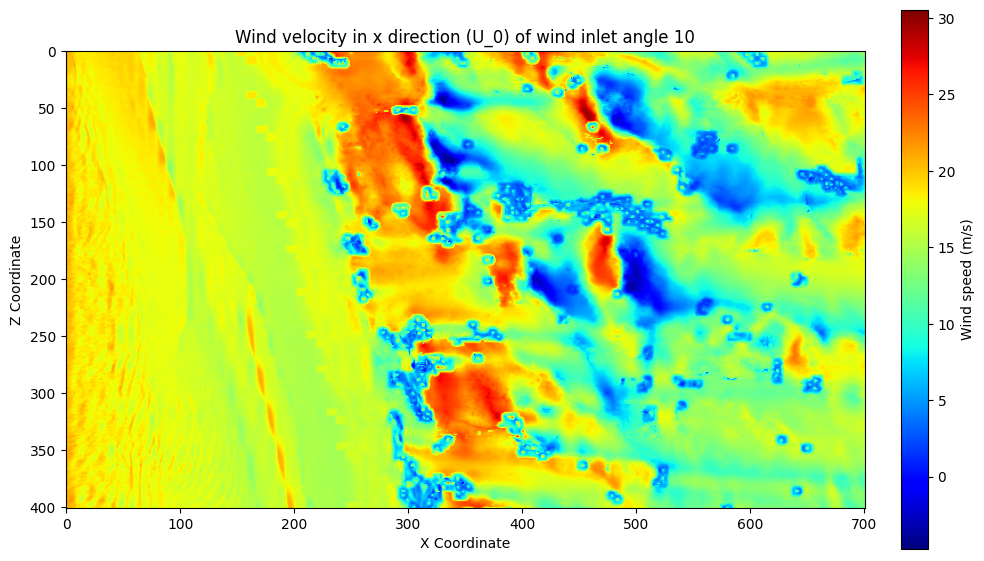

In [ ]:
import matplotlib.pyplot as plt
# 2-D plot with error color scale
plt.figure(figsize=(10, 8))
#plt.imshow(topo, cmap='terrain', extent=[0, topo.shape[1], 0, topo.shape[0]])
#plt.colorbar(label='Height')
plt.imshow(U_0_flipped, cmap='jet')
plt.colorbar(label='Wind speed (m/s)', aspect=20, shrink=0.7, pad=0.04, fraction=0.08)
plt.title('Wind velocity in x direction (U_0) of wind inlet angle 10')
plt.xlabel('X Coordinate')
plt.ylabel('Z Coordinate')

plt.tight_layout()
plt.show()

## Plot the 9 graphs of ground truth, prediction and error data
- of angle -60

In [ ]:
data = pd.read_csv(directory + csv_files[2])

In [ ]:

ground_truths = []
ground_truths.append(data.U_0)
ground_truths.append(data.U_1)
ground_truths.append(data.U_2)

predictions = []
predictions.append(data.pred_U_0)
predictions.append(data.pred_U_1)
predictions.append(data.pred_U_2)

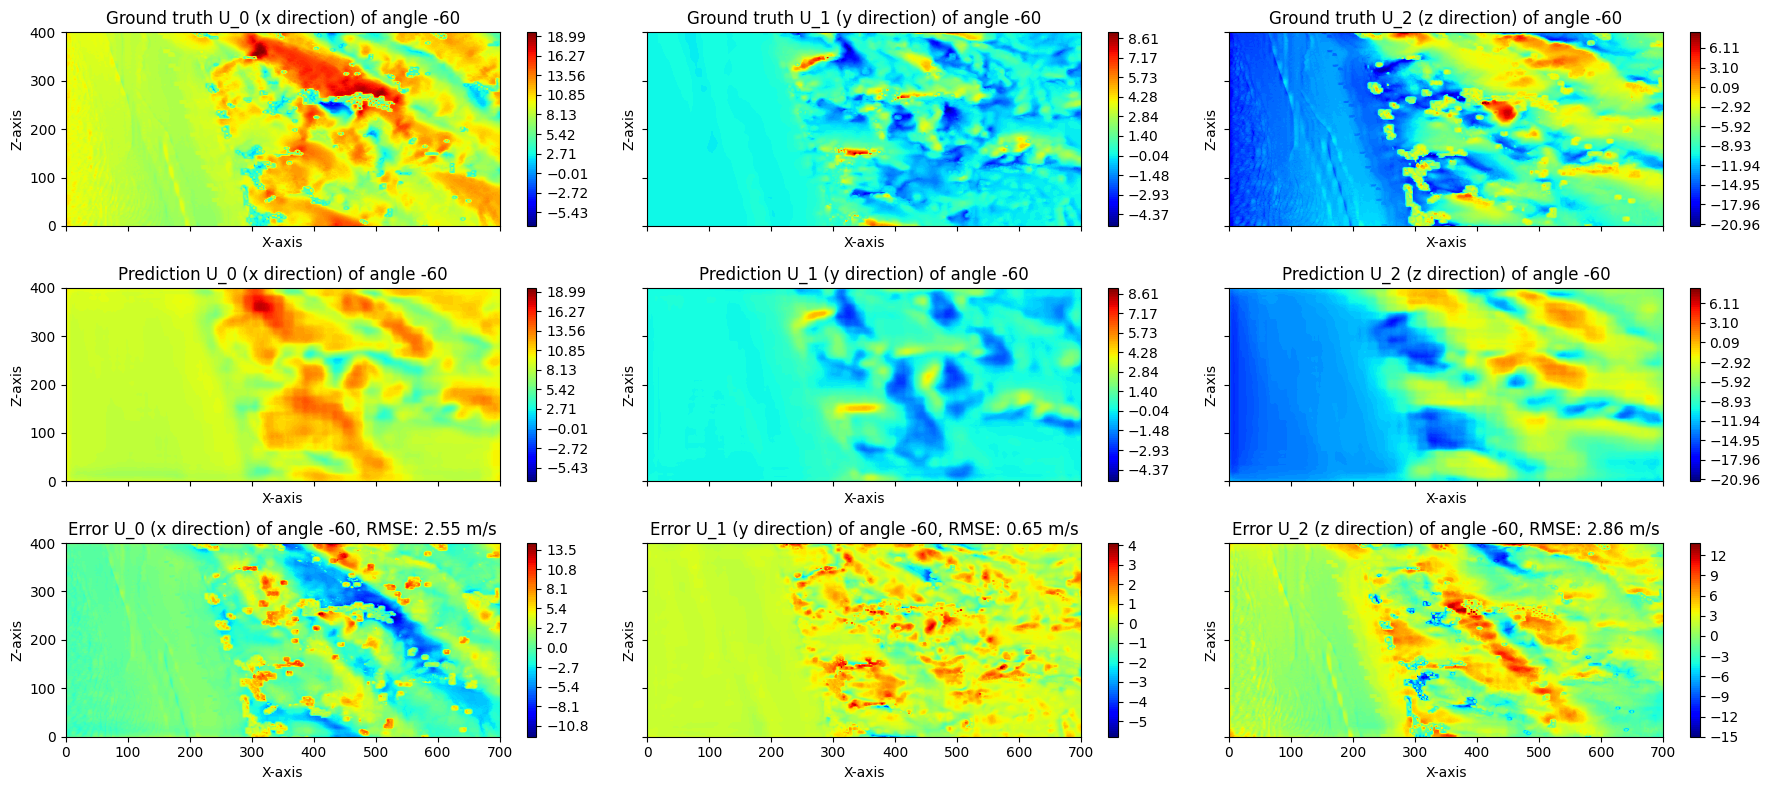

In [ ]:
#Used to keep prediction and True velocity values on the same axis
levels_U_0 = np.linspace(min(data.U_0.min(), data.pred_U_0.min()), max(data.U_0.max(), data.pred_U_0.max()), 100)
levels_U_1 = np.linspace(min(data.U_1.min(), data.pred_U_1.min()), max(data.U_1.max(), data.pred_U_1.max()), 100)
levels_U_2 = np.linspace(min(data.U_2.min(), data.pred_U_2.min()), max(data.U_2.max(), data.pred_U_2.max()), 100)
levels = [levels_U_0, levels_U_1, levels_U_2]

rmses = [2.55, 0.65, 2.86]

direction = ['x direction', 'y direction', 'z direction']

## Plot and save the different graphs
# Plot the different graphs
fig, axes = plt.subplots(3, 3, figsize=(18, 8), sharex=True, sharey=True)  # Create a figure with 3 subplots
for j in range(3):
    # plot ground truths
    plot_values = data.loc[:, f'U_{j}'] # Adjust this according to your data structure

    plot_values = pd.DataFrame(plot_values.values.reshape(401, 701))

    ax = axes[0, j]
    p1 = ax.contourf(plot_values, levels=levels[j], cmap='jet')
    fig.colorbar(p1, ax=ax)
    ax.title.set_text(f'Ground truth U_{j} ({direction[j]}) of angle -60')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Z-axis')

    # plot predictions
    plot_values = data.loc[:, f'pred_U_{j}'] # Adjust this according to your data structure

    plot_values = pd.DataFrame(plot_values.values.reshape(401, 701))

    ax = axes[1, j]
    p2 = ax.contourf(plot_values, levels=levels[j], cmap='jet')
    fig.colorbar(p2, ax=ax)
    ax.set_title(f'Prediction U_{j} ({direction[j]}) of angle -60')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Z-axis')

    # plot errors
    plot_values = data.loc[:, f'pred_U_{j}'] - data.loc[:, f'U_{j}'] # Adjust this according to your data structure

    plot_values = pd.DataFrame(plot_values.values.reshape(401, 701))

    ax = axes[2, j]
    p3 = ax.contourf(plot_values, levels=100, cmap='jet')
    fig.colorbar(p3, ax=ax)
    ax.set_title(f'Error U_{j} ({direction[j]}) of angle -60, RMSE: {rmses[j]:.2f} m/s')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Z-axis')

plt.tight_layout()
plt.show()

## Load best model, select one fold and plot train, test and validation rmse over all angles

In [ ]:
directory = '' # Give the dir to the trained model data

angle_dirs = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

In [ ]:
model_dir = directory+angle_dirs[fold]

In [ ]:
test_indices = [[0, 3], [2, 5], [9, 11], [1, 7], [8, 10]]
val_indices = [4, 6, 12]


In [ ]:
from torch.utils.data import Subset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

count = fold
test_pair = test_indices[fold]

# Define backbone
backbone = 'densenet121' #'efficientnetb7' #'resnet152' # 'densenet121'  #
# Define & compile the model
model = FPN(backbone_name=backbone, encoder_weights=None, input_shape=(2, None, None), classes = 3, activation = 'linear')
#model.compile('Adam', loss=loss, metrics=[metric])


# Load the best model
model.load_weights(model_dir + '/best_model.h5')

# Define test set
test_set = Subset(dataset, test_pair)

# Define validation set
validation_set = Subset(dataset, val_indices)

# Define train set
exclude = test_pair + val_indices
train_indices = np.arange(0, 13)            # Total of 13 datapoints
train_indices = np.delete(train_indices, exclude) # Exclude the test and validation datapoints from training
train_set = Subset(dataset, train_indices)

# Define loaders
train_loader = Dataloder(dataset = train_set)
validation_loader = Dataloder(dataset = validation_set)
test_loader = Dataloder(dataset = test_set)

/usr/local/lib/python3.10/dist-packages/keras_applications/imagenet_utils.py:269: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


In [ ]:
rmse_dict = {}

In [ ]:
import time

In [ ]:
all_pred_times = []

In [ ]:
# Get rmse for all training angles
for i in range(len(train_loader)):

  # Get the inlet angle:
  output_dir = annotations.output_file[train_indices[i]] #[test_pair[i]] # adjust to the correct LOOCV
  input_dir = annotations.input_file[train_indices[i]] #[test_pair[i]] # adjust to the correct LOOCV
  test_label = label_dir + "/" + output_dir
  angle = extract_angle(test_label)

  # Compute the std and mean of the U_i to get the orgininal values
  label_path = os.path.join(label_dir, annotations.iloc[train_indices[i], 1]) # Maak csv met alle namen van bestanden (X en Y)
  label = pd.read_csv(label_path) #self.img_labels.iloc[idx, 1] # to di
  U_0 = label.loc[:, "U_0"]
  mean_0 = np.mean(U_0)
  std_0  = np.std(U_0)

  U_1 = label.loc[:, "U_1"]
  mean_1 = np.mean(U_1)
  std_1  = np.std(U_1)

  U_2 = label.loc[:, "U_2"]
  mean_2 = np.mean(U_2)
  std_2  = np.std(U_2)

  # Predict on the correct testset

  start_time = time.time()
  prediction = model.predict(train_loader[i][0])
  end_time = time.time()
  prediction_time = end_time - start_time
  all_pred_times.append(prediction_time)


  # Rescale the predictions and ground truth data
  ground_truth_0 = train_loader[i][1][0][0][:-15, :-3]*std_0 + mean_0
  ground_truth_1 = train_loader[i][1][0][1][:-15, :-3]*std_1 + mean_1
  ground_truth_2 = train_loader[i][1][0][2][:-15, :-3]*std_2 + mean_2 # probably needs and extra [0] between [1] and [2]
  ground_truths = [ground_truth_0, ground_truth_1, ground_truth_2]

  prediction_0 = prediction[0][0][:-15, :-3]*std_0 + mean_0
  prediction_1 = prediction[0][1][:-15, :-3]*std_1 + mean_1
  prediction_2 = prediction[0][2][:-15, :-3]*std_2 + mean_2
  predictions = [prediction_0, prediction_1, prediction_2]

  # Compute model performance with fold i
  actual_rmse_value_0 = np.sqrt(mean_squared_error(ground_truth_0, prediction_0))
  actual_rmse_value_1 = np.sqrt(mean_squared_error(ground_truth_1, prediction_1))
  actual_rmse_value_2 = np.sqrt(mean_squared_error(ground_truth_2, prediction_2))
  actual_rmse = [actual_rmse_value_0, actual_rmse_value_1, actual_rmse_value_2]

  # Compute model performance with fold i
  standardized_rmse_value_0 = np.sqrt(mean_squared_error(train_loader[i][1][0][0][:-15, :-3], prediction[0][0][:-15, :-3]))
  standardized_rmse_value_1 = np.sqrt(mean_squared_error(train_loader[i][1][0][1][:-15, :-3], prediction[0][1][:-15, :-3]))
  standardized_rmse_value_2 = np.sqrt(mean_squared_error(train_loader[i][1][0][2][:-15, :-3], prediction[0][2][:-15, :-3]))
  standardized_rmse = [standardized_rmse_value_0, standardized_rmse_value_1, standardized_rmse_value_2]

  rmse_dict[angle] = {
                'rmse_0': [],
                'rmse_1': [],
                'rmse_2': []
            }

  rmse_dict[angle]['rmse_0'].append(round(standardized_rmse_value_0, 2))
  rmse_dict[angle]['rmse_1'].append(round(standardized_rmse_value_1, 2))
  rmse_dict[angle]['rmse_2'].append(round(standardized_rmse_value_2, 2))

1/1 [==============================] - 0s 28ms/step


In [ ]:
# Get rmse for all validation angles
for i in range(len(validation_loader)):

  # Get the inlet angle:
  output_dir = annotations.output_file[val_indices[i]] #[test_pair[i]] # adjust to the correct LOOCV
  input_dir = annotations.input_file[val_indices[i]] #[test_pair[i]] # adjust to the correct LOOCV
  test_label = label_dir + "/" + output_dir
  angle = extract_angle(test_label)


  # Compute the std and mean of the U_i to get the orgininal values
  label_path = os.path.join(label_dir, annotations.iloc[val_indices[i], 1]) # Maak csv met alle namen van bestanden (X en Y)
  label = pd.read_csv(label_path) #self.img_labels.iloc[idx, 1] # to di
  U_0 = label.loc[:, "U_0"]
  mean_0 = np.mean(U_0)
  std_0  = np.std(U_0)

  U_1 = label.loc[:, "U_1"]
  mean_1 = np.mean(U_1)
  std_1  = np.std(U_1)

  U_2 = label.loc[:, "U_2"]
  mean_2 = np.mean(U_2)
  std_2  = np.std(U_2)



  # Predict on the correct testset
  start_time = time.time()
  prediction = model.predict(validation_loader[i][0])
  end_time = time.time()
  prediction_time = end_time - start_time
  all_pred_times.append(prediction_time)


  # Rescale the predictions and ground truth data
  ground_truth_0 = validation_loader[i][1][0][0][:-15, :-3]*std_0 + mean_0
  ground_truth_1 = validation_loader[i][1][0][1][:-15, :-3]*std_1 + mean_1
  ground_truth_2 = validation_loader[i][1][0][2][:-15, :-3]*std_2 + mean_2 # probably needs and extra [0] between [1] and [2]
  ground_truths = [ground_truth_0, ground_truth_1, ground_truth_2]

  prediction_0 = prediction[0][0][:-15, :-3]*std_0 + mean_0
  prediction_1 = prediction[0][1][:-15, :-3]*std_1 + mean_1
  prediction_2 = prediction[0][2][:-15, :-3]*std_2 + mean_2
  predictions = [prediction_0, prediction_1, prediction_2]

  # Compute model performance with fold i
  actual_rmse_value_0 = np.sqrt(mean_squared_error(ground_truth_0, prediction_0))
  actual_rmse_value_1 = np.sqrt(mean_squared_error(ground_truth_1, prediction_1))
  actual_rmse_value_2 = np.sqrt(mean_squared_error(ground_truth_2, prediction_2))
  actual_rmse = [actual_rmse_value_0, actual_rmse_value_1, actual_rmse_value_2]

  # Compute model performance with fold i
  standardized_rmse_value_0 = np.sqrt(mean_squared_error(validation_loader[i][1][0][0][:-15, :-3], prediction[0][0][:-15, :-3]))
  standardized_rmse_value_1 = np.sqrt(mean_squared_error(validation_loader[i][1][0][1][:-15, :-3], prediction[0][1][:-15, :-3]))
  standardized_rmse_value_2 = np.sqrt(mean_squared_error(validation_loader[i][1][0][2][:-15, :-3], prediction[0][2][:-15, :-3]))
  standardized_rmse = [standardized_rmse_value_0, standardized_rmse_value_1, standardized_rmse_value_2]

  rmse_dict[angle] = {
                'rmse_0': [],
                'rmse_1': [],
                'rmse_2': []
            }

  rmse_dict[angle]['rmse_0'].append(round(standardized_rmse_value_0, 2))
  rmse_dict[angle]['rmse_1'].append(round(standardized_rmse_value_1, 2))
  rmse_dict[angle]['rmse_2'].append(round(standardized_rmse_value_2, 2))

1/1 [==============================] - 0s 31ms/step


In [ ]:
# Get rmse for all test angles
for i in range(len(test_loader)):

  # Get the inlet angle:
  output_dir = annotations.output_file[test_pair[i]] #[test_pair[i]] # adjust to the correct LOOCV
  input_dir = annotations.input_file[test_pair[i]] #[test_pair[i]] # adjust to the correct LOOCV
  test_label = label_dir + "/" + output_dir
  angle = extract_angle(test_label)



  # Compute the std and mean of the U_i to get the orgininal values
  label_path = os.path.join(label_dir, annotations.iloc[test_pair[i], 1]) # Maak csv met alle namen van bestanden (X en Y)
  label = pd.read_csv(label_path) #self.img_labels.iloc[idx, 1] # to di
  U_0 = label.loc[:, "U_0"]
  mean_0 = np.mean(U_0)
  std_0  = np.std(U_0)

  U_1 = label.loc[:, "U_1"]
  mean_1 = np.mean(U_1)
  std_1  = np.std(U_1)

  U_2 = label.loc[:, "U_2"]
  mean_2 = np.mean(U_2)
  std_2  = np.std(U_2)



  # Predict on the correct testset
  start_time = time.time()
  prediction = model.predict(test_loader[i][0])
  end_time = time.time()
  prediction_time = end_time - start_time
  all_pred_times.append(prediction_time)


  # Rescale the predictions and ground truth data
  ground_truth_0 = test_loader[i][1][0][0][:-15, :-3]*std_0 + mean_0
  ground_truth_1 = test_loader[i][1][0][1][:-15, :-3]*std_1 + mean_1
  ground_truth_2 = test_loader[i][1][0][2][:-15, :-3]*std_2 + mean_2 # probably needs and extra [0] between [1] and [2]
  ground_truths = [ground_truth_0, ground_truth_1, ground_truth_2]

  prediction_0 = prediction[0][0][:-15, :-3]*std_0 + mean_0
  prediction_1 = prediction[0][1][:-15, :-3]*std_1 + mean_1
  prediction_2 = prediction[0][2][:-15, :-3]*std_2 + mean_2
  predictions = [prediction_0, prediction_1, prediction_2]

  # Compute model performance with fold i
  actual_rmse_value_0 = np.sqrt(mean_squared_error(ground_truth_0, prediction_0))
  actual_rmse_value_1 = np.sqrt(mean_squared_error(ground_truth_1, prediction_1))
  actual_rmse_value_2 = np.sqrt(mean_squared_error(ground_truth_2, prediction_2))
  actual_rmse = [actual_rmse_value_0, actual_rmse_value_1, actual_rmse_value_2]

  # Compute model performance with fold i
  standardized_rmse_value_0 = np.sqrt(mean_squared_error(test_loader[i][1][0][0][:-15, :-3], prediction[0][0][:-15, :-3]))
  standardized_rmse_value_1 = np.sqrt(mean_squared_error(test_loader[i][1][0][1][:-15, :-3], prediction[0][1][:-15, :-3]))
  standardized_rmse_value_2 = np.sqrt(mean_squared_error(test_loader[i][1][0][2][:-15, :-3], prediction[0][2][:-15, :-3]))
  standardized_rmse = [standardized_rmse_value_0, standardized_rmse_value_1, standardized_rmse_value_2]


  rmse_dict[angle] = {
                'rmse_0': [],
                'rmse_1': [],
                'rmse_2': []
            }

  rmse_dict[angle]['rmse_0'].append(round(standardized_rmse_value_0, 2))
  rmse_dict[angle]['rmse_1'].append(round(standardized_rmse_value_1, 2))
  rmse_dict[angle]['rmse_2'].append(round(standardized_rmse_value_2, 2))

1/1 [==============================] - 0s 28ms/step


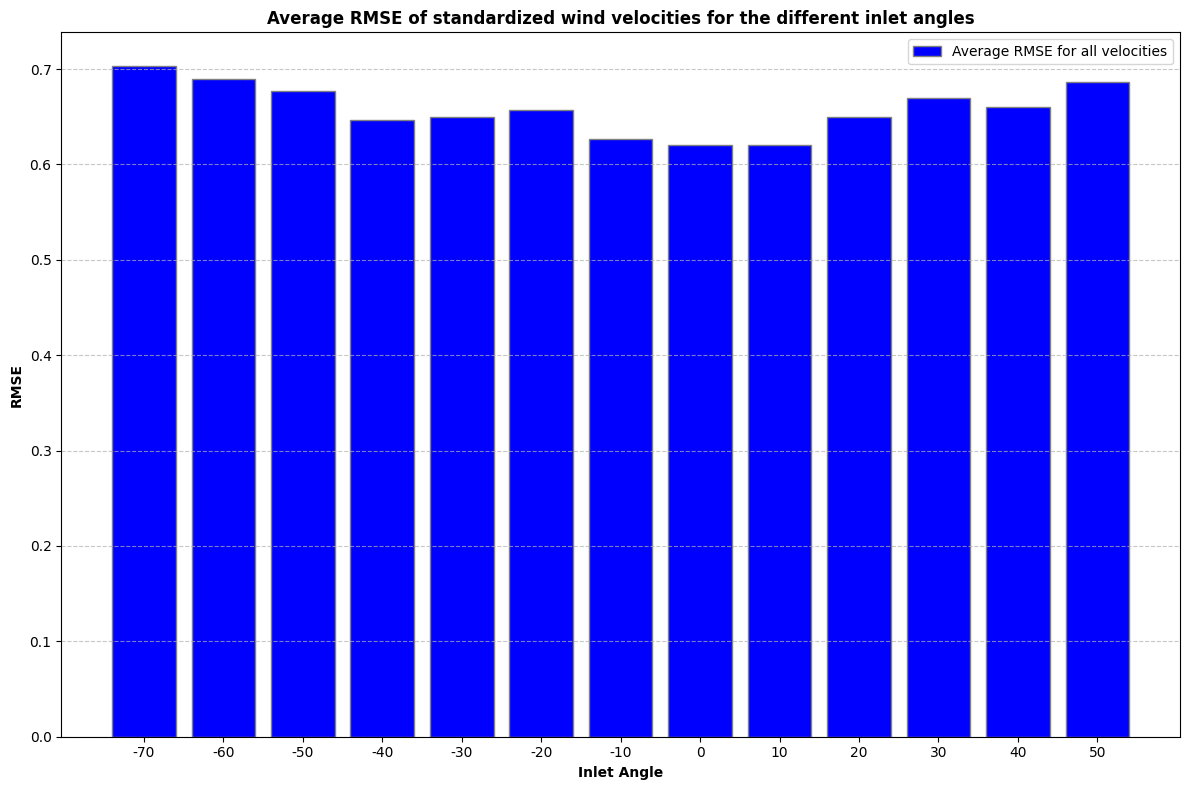

In [ ]:
# Plot the entire histogram
# Not yet looking at what the train, test and val datasets are


angles = np.sort(list(rmse_dict.keys()))
rmse_0 = [rmse_dict[angle]['rmse_0'][0] for angle in angles]
rmse_1 = [rmse_dict[angle]['rmse_1'][0] for angle in angles]
rmse_2 = [rmse_dict[angle]['rmse_2'][0] for angle in angles]
rmse = np.mean([rmse_0, rmse_1, rmse_2], axis=0)

bar_width = 0.2  # Width of the bars

# Positions of the bars on the x-axis
r1 = np.arange(len(angles))

# Create the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, rmse, color='blue', edgecolor='grey', label='Average RMSE for all velocities')

# Add labels
plt.xlabel('Inlet Angle', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title(f"Average RMSE of standardized wind velocities for the different inlet angles", fontweight='bold')
plt.xticks([r for r in range(len(angles))], angles)
plt.legend()

# Add a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
#plt.savefig(f'{model}_std_rmse_histogram.png')
plt.show()


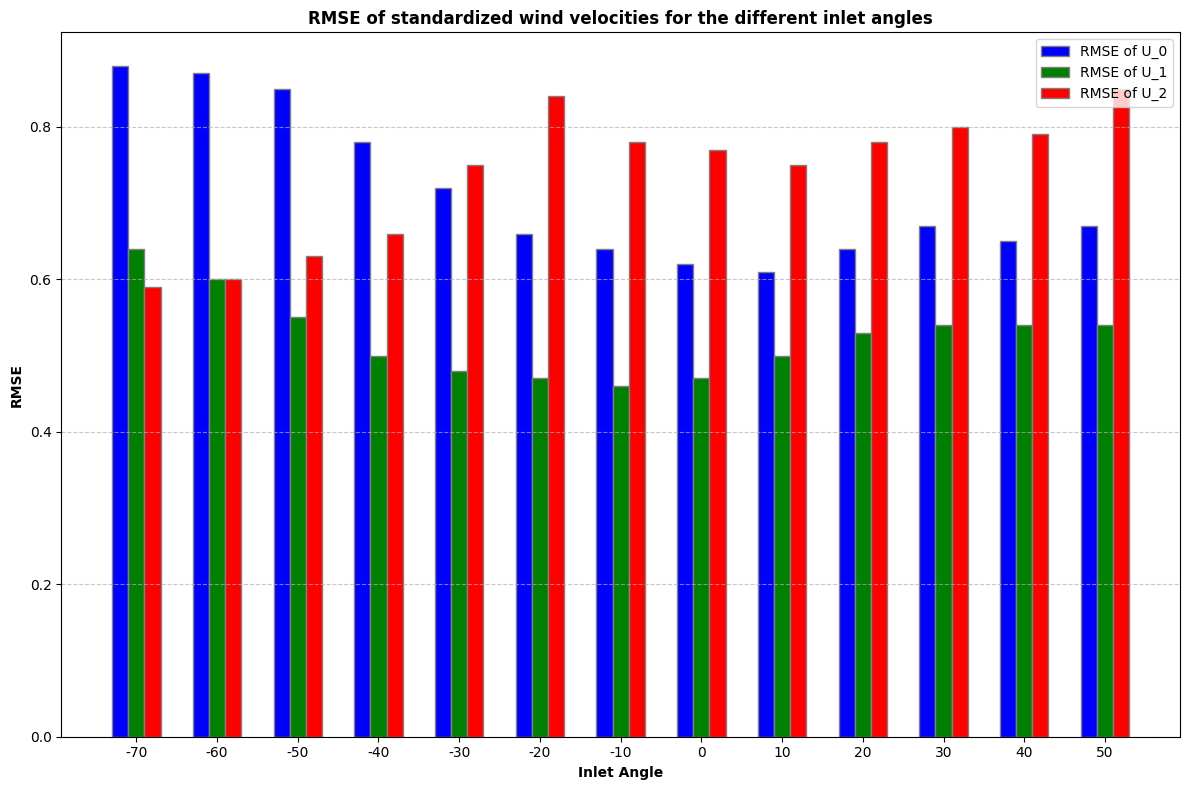

In [ ]:
#angles = list(data.keys())
angles = np.sort(list(rmse_dict.keys()))
rmse_0 = [rmse_dict[angle]['rmse_0'][0] for angle in angles]
rmse_1 = [rmse_dict[angle]['rmse_1'][0] for angle in angles]
rmse_2 = [rmse_dict[angle]['rmse_2'][0] for angle in angles]

bar_width = 0.2  # Width of the bars

# Positions of the bars on the x-axis
r1 = np.arange(len(angles))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, rmse_0, color='blue', width=bar_width, edgecolor='grey', label='RMSE of U_0')
plt.bar(r2, rmse_1, color='green', width=bar_width, edgecolor='grey', label='RMSE of U_1')
plt.bar(r3, rmse_2, color='red', width=bar_width, edgecolor='grey', label='RMSE of U_2')

# Add labels
plt.xlabel('Inlet Angle', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title(f"RMSE of standardized wind velocities for the different inlet angles", fontweight='bold')
plt.xticks([r + bar_width for r in range(len(angles))], angles)
plt.legend()

# Add a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
#plt.savefig(f'{model}_std_rmse_histogram.png')
plt.show()


In [ ]:
rmse_dict

{-10: {'rmse_0': [0.64], 'rmse_1': [0.64], 'rmse_2': [0.64]},
 -40: {'rmse_0': [0.78], 'rmse_1': [0.78], 'rmse_2': [0.78]},
 -60: {'rmse_0': [0.87], 'rmse_1': [0.87], 'rmse_2': [0.87]},
 -70: {'rmse_0': [0.88], 'rmse_1': [0.88], 'rmse_2': [0.88]},
 10: {'rmse_0': [0.61], 'rmse_1': [0.61], 'rmse_2': [0.61]},
 40: {'rmse_0': [0.65], 'rmse_1': [0.65], 'rmse_2': [0.65]},
 50: {'rmse_0': [0.67], 'rmse_1': [0.67], 'rmse_2': [0.67]},
 -20: {'rmse_0': [0.66], 'rmse_1': [0.66], 'rmse_2': [0.66]},
 0: {'rmse_0': [0.62], 'rmse_1': [0.62], 'rmse_2': [0.62]},
 30: {'rmse_0': [0.67], 'rmse_1': [0.67], 'rmse_2': [0.67]},
 -30: {'rmse_0': [0.72], 'rmse_1': [0.72], 'rmse_2': [0.72]},
 20: {'rmse_0': [0.64], 'rmse_1': [0.64], 'rmse_2': [0.64]},
 -50: {'rmse_0': [0.85], 'rmse_1': [0.85], 'rmse_2': [0.85]}}

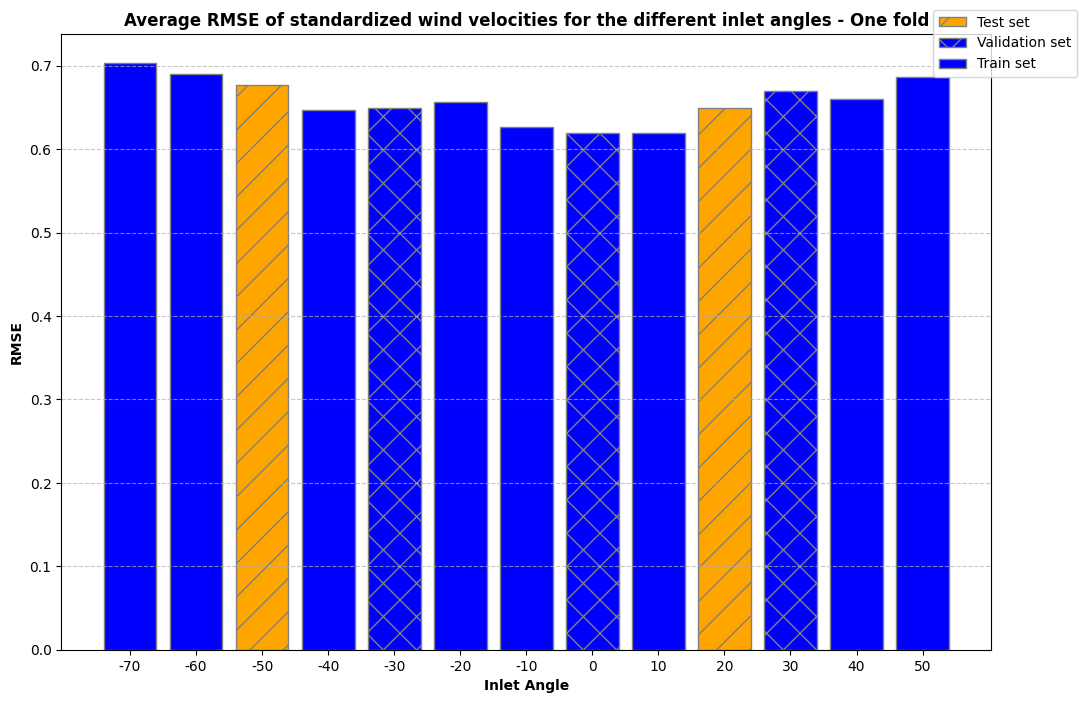

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# Function to plot the histogram
def plot_histogram_with_hatching(rmse_dict, hatched_angles_train, hatched_angles_val):
    angles = np.sort(list(rmse_dict.keys()))
    rmse_0 = [rmse_dict[angle]['rmse_0'][0] for angle in angles]
    rmse_1 = [rmse_dict[angle]['rmse_1'][0] for angle in angles]
    rmse_2 = [rmse_dict[angle]['rmse_2'][0] for angle in angles]
    rmse = np.mean([rmse_0, rmse_1, rmse_2], axis=0)

    bar_width = 0.2  # Width of the bars

    # Positions of the bars on the x-axis
    r1 = np.arange(len(angles))

    # Create the plot
    plt.figure(figsize=(12, 8))

    for i in range(len(angles)):
        if angles[i] in hatched_angles_train:
            plt.bar(r1[i], rmse[i], color='Orange', edgecolor='grey', label='Test set average RMSE' if i == 0 else "", hatch='/')
        elif angles[i] in hatched_angles_val:
            plt.bar(r1[i], rmse[i], color='blue', edgecolor='grey', label='Validation set average RMSE' if i == 0 else "", hatch='x')
        else:
            plt.bar(r1[i], rmse[i], color='blue', edgecolor='grey', label='Train set average RMSE' if i == 0 else "")

    # Add labels
    plt.xlabel('Inlet Angle', fontweight='bold')
    plt.ylabel('RMSE', fontweight='bold')
    plt.title(f"Average RMSE of standardized wind velocities for the different inlet angles - One fold", fontweight='bold')
    plt.xticks([r for r in range(len(angles))], angles)
    #plt.legend(['Train set', 'Validation set', 'Test set'], loc='upper right')


        # Create custom legend
    legend_elements = [
        Patch(facecolor='Orange', edgecolor='grey', hatch='/', label='Test set'),
        Patch(facecolor='blue', edgecolor='grey', hatch='x', label='Validation set'),
        Patch(facecolor='blue', edgecolor='grey', label='Train set')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.1, 1.05)) #, loc='upper right')


    # Add a grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    #plt.tight_layout()

    # Save and show the plot
    # plt.savefig(f'{model}_std_rmse_histogram.png')
    plt.show()

# Example usage
#hatched_angles_train = [-70, -60, -40, -30, -10, 10, 40, 50] # Angles to be marked with a diagonal line
hatched_angles_test = [-50, 20]
hatched_angles_val = [-30, 0 , 30]  # Angles to be marked with a diagonal line
plot_histogram_with_hatching(rmse_dict, hatched_angles_test, hatched_angles_val)

